## import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import math
import datetime

import seaborn as sns
import pandas as pd
import librosa
import librosa.display
try:
    from dtw import dtw
except:
    !pip install dtw
    from dtw import dtw


try:
    from pydub import AudioSegment
except:
    !pip install pydub
    from pydub import AudioSegment

## Selection aléatoire de quelques drums

In [2]:
def quoiChoose(p, interval):
    res = []
    N = (interval[1] - interval[0])+1
    cb = int(N*p)

    tab = list(range(interval[0],interval[1]+1))
    print(tab)
    while len(res) < cb:
        c = random.choice(tab)
        if c not in res:
            res.append(c)
    return res

quoiChoose( 0.1, [1,40] )

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


[9, 25, 11, 14]

## Choix du drumkit 

In [3]:
def CreerDossierSauvegarde(ou,doss):
    nomEmplacementSauvegarde = ou + "/" + doss
    if not os.path.exists(nomEmplacementSauvegarde):
        os.mkdir(nomEmplacementSauvegarde)
        return nomEmplacementSauvegarde
    else:
        return nomEmplacementSauvegarde


In [4]:
# Le dossier de sauvegarde DRIVE
from google.colab import drive,files
drive.mount('/content/gdrive')
!ls /content

DRUMKIT_LEDOSSIER = "/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/Savage Drum Kit"
print(os.listdir(DRUMKIT_LEDOSSIER))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data
['808s', 'Claps', 'Cymbals', 'FX', 'Hi Hats', 'Hits', 'Kicks', 'Melodies', 'Mixer Presets', 'Open Hats', 'Percussion', 'Scales', 'Snaps', 'Snares', 'Vox']


In [5]:

def get_all_directory(kit_path,l_veski, res = []):
    if os.path.exists(str(kit_path)):
        for fic in os.listdir(kit_path):
            if fic not in l_veski:
                fic = kit_path + "/" + fic
                if os.path.isdir(fic): #si dossier
                    res.append(fic)
                    res = get_all_directory(fic,l_veski,res)
                    #print(fic)
    return res

l_dossiers_veski = ['Fx - textures','BONUS',"Loops","loops",'Melodies', 'Mixer Presets', 'Scales' ]
all_dossier_a_analyser_DRUMKIT = sorted(list(set(get_all_directory(DRUMKIT_LEDOSSIER,l_dossiers_veski))))

def get_names_files_on(doss):
    listeFichiersAUDIO_names = np.array([f"[{i}] " +  fic for i,fic in enumerate(os.listdir(doss)) if fic.split(".")[-1] in [ "wav"]  ])
    listeFichiersAUDIO =  np.array([doss + "/" + fic for fic in os.listdir(doss) if fic.split(".")[-1] in ["wav"]  ])
    return listeFichiersAUDIO_names, listeFichiersAUDIO 

print(np.array(list(all_dossier_a_analyser_DRUMKIT)))


['/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/Savage Drum Kit/808s'
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/Savage Drum Kit/Claps'
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/Savage Drum Kit/Cymbals'
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/Savage Drum Kit/FX'
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/Savage Drum Kit/Hi Hats'
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/Savage Drum Kit/Hits'
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/Savage Drum Kit/Kicks'
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/Savage Drum Kit/Open Hats'
 '/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data/Savage Drum Kit/Percussion'
 '/content/gdrive/Shareddrives/# Zone de Code #

In [6]:
print(os.listdir('/content/gdrive/Shareddrives/# Zone de Code #/Zone de lavage de Drumkits - Data'))

['FabeStar ~ DrumStar', 'All Holy Drum Kit', 'Hollow Drum Kit', 'Untitled0.ipynb', 'Savage Drum Kit', 'Material ~ Drum Kit (DrumDigger)', 'Snare', 'prodbyjack - THEDRUMCOLLECTION', 'XXX DRUM KIT', 'Cxdy ~ Drum Kit', 'TheKitPlug ~ Drum Kit']


## Test • Comparer 2 audios

In [7]:
one_seconds = 1000

all_dossier_a_analyser_DRUMKIT = sorted(list(set(get_all_directory(DRUMKIT_LEDOSSIER,l_dossiers_veski))))
dir_drums = all_dossier_a_analyser_DRUMKIT[0]
    
listeFichiersAUDIO_names, listeFichiersAUDIO = get_names_files_on(dir_drums)

file1 = listeFichiersAUDIO[-3]
file2 = listeFichiersAUDIO[2]


def AfficherAudio(filename_list, cut_sec):
    if filename_list:
        song = AudioSegment.from_wav(filename_list[0])[0:one_seconds* cut_sec]
        if len(filename_list) > 1:
            try:
                for f in filename_list[1:]:
                    song += AudioSegment.from_wav(f)[0:one_seconds* cut_sec]
            except:
                print("*")

    return song

AfficherAudio([file1,file2],3)



duree 1 : 3.1542857142857144
duree 2 : 1.1350113378684807
Normalized distance between the two sounds: 27606.301467895508


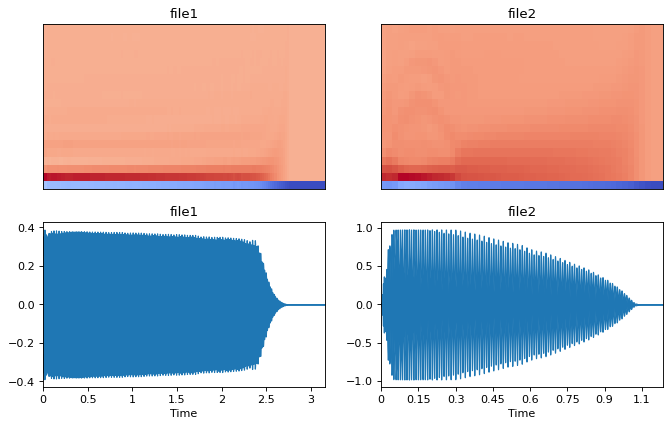

In [8]:
#Loading audio files

plt.figure(figsize=(10, 6), dpi=80)

plt.subplot(2, 2, 3) 
plt.title("file1")
y1, sr1 = librosa.load(file1)
print("duree 1 :",librosa.get_duration(y1))
librosa.display.waveplot(y1, sr1)

plt.subplot(2, 2, 4) 
plt.title("file2")
y2, sr2 = librosa.load(file2) 
print("duree 2 :",librosa.get_duration(y2))
librosa.display.waveplot(y2, sr2)

#Showing multiple plots using subplot
plt.subplot(2, 2, 1) 
plt.title("file1")
mfcc1 = librosa.feature.mfcc(y1,sr1)   #Computing MFCC values
librosa.display.specshow(mfcc1)

plt.subplot(2, 2, 2)
plt.title("file2")
mfcc2 = librosa.feature.mfcc(y2, sr2)
librosa.display.specshow(mfcc2)

from numpy.linalg import norm
dist, cost, acc_cost, path = dtw(mfcc1.T, mfcc2.T, dist=lambda x, y: norm(x - y, ord=1))
print('Normalized distance between the two sounds:', dist )  # 0 for similar audios 

(-0.5, 48.5)

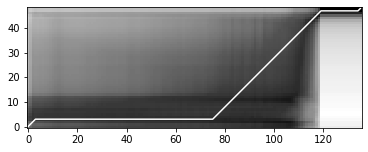

In [9]:
plt.imshow(cost.T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.plot(path[0], path[1], 'w') #creating plot for DTW
plt.xlim((-0.5, cost.shape[0]-0.5))
plt.ylim((-0.5, cost.shape[1]-0.5))

## Test • Comparer un dossier d'audios

## -> Comparer un drumkit entier

### Les fonctions

In [10]:
%%time

def distance_entre_2_audios(file1,file2):
    try:
        #Loading audio files
        y1, sr1 = librosa.load(file1) 
        y2, sr2 = librosa.load(file2) 

        mfcc1 = librosa.feature.mfcc(y1,sr1)   #Computing MFCC values
        mfcc2 = librosa.feature.mfcc(y2, sr2)

        dist, cost, acc_cost, path = dtw(mfcc1.T, mfcc2.T, dist=lambda x, y: norm(x - y, ord=1))
        return dist
    except:
        print("error calc distance")
        return np.nan

distance_entre_2_audios(file1,file2)

CPU times: user 345 ms, sys: 97.6 ms, total: 442 ms
Wall time: 335 ms


In [11]:
def matrice_similitude_listes_audios( l_audios):
    N = len(l_audios)
    tab = np.empty((N,N))
    tab[:] = np.NaN

    for i,fic1 in enumerate(l_audios):
        for j,fic2 in enumerate(l_audios):
            if j < i:
                
                tab[i][j] = distance_entre_2_audios(fic1,fic2)


            print(f"{int((i/len(l_audios))*100)}%", end="")
    return tab

In [12]:
def CreateHeatMap(tab_dist, col_names ,title):
    df = pd.DataFrame(tab_dist, columns= col_names,index= col_names)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(32,32))  
        plt.title(title, fontsize=20)
        ax = sns.heatmap(df,linewidths=.1)
    figure = ax.get_figure()  
    figure.savefig(DRIVE_LEDOSSIER+"/"+title+".png", dpi=400)
    plt.show()

def heatMap_file_exist(title):
    return os.path.exists(DRIVE_LEDOSSIER+"/"+title+".png")

In [13]:
def get_drums_similaires(tab, seuil, listeFichiersAUDIO):
    res = []
    #format_line = '# {:>45} <--> {:>45} : {:>5} '
    for i in range(np.shape(tab)[0]):
        for j in range(np.shape(tab)[1]):
            if j < i:
                if tab[i][j] < seuil:
                    res.append( (     listeFichiersAUDIO[i].split("/")[-1],  listeFichiersAUDIO[j].split("/")[-1], round(tab[i][j],1)       ) ) 

    #trié #TODO    
    return res

def print_drums_similaires(leSeuil,res):
    text = f"### {len(res)} couples trouvés - seuil : {leSeuil} ###\n"
    format_line = '# {:>25} <--> {:>25} : {:>5} '
    for i,j, v in res:
        text += format_line.format(i, j, v)
        if v < leSeuil*0.5:
            text += " !"*5
        print( format_line.format(i, j, v)  )
        text += "\n"

    return text,len(res)

def round_bis(value,step = 1):
    inv = 1 /step
    res = round(value * inv) / inv

    if res < value:
        return res + step
    else:
        return res

def write_resultats_drums(tab, title,listeFichiersAUDIO ):
    #leSeuil = round_bis(np.nanmin(tab), 500 )
    leSeuil = 1250
    text, nb_find = print_drums_similaires(leSeuil,  get_drums_similaires(tab,leSeuil,listeFichiersAUDIO)   )

    if nb_find > 0:
        with open(DRIVE_LEDOSSIER+"/" + title + '.txt', 'w') as f:
            f.write(text)



#leSeuil = round_bis(np.nanmin(tab), 100)

### GO

################################################################################ 8% (1/12) 
### Zone de lavage de Drumkits - Data-Savage Drum Kit-808s
0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%2%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%19%19%19%19%19%19%19%19%19%19%19%19%19%19%19%19%19%19%19%19%19%19%19%1

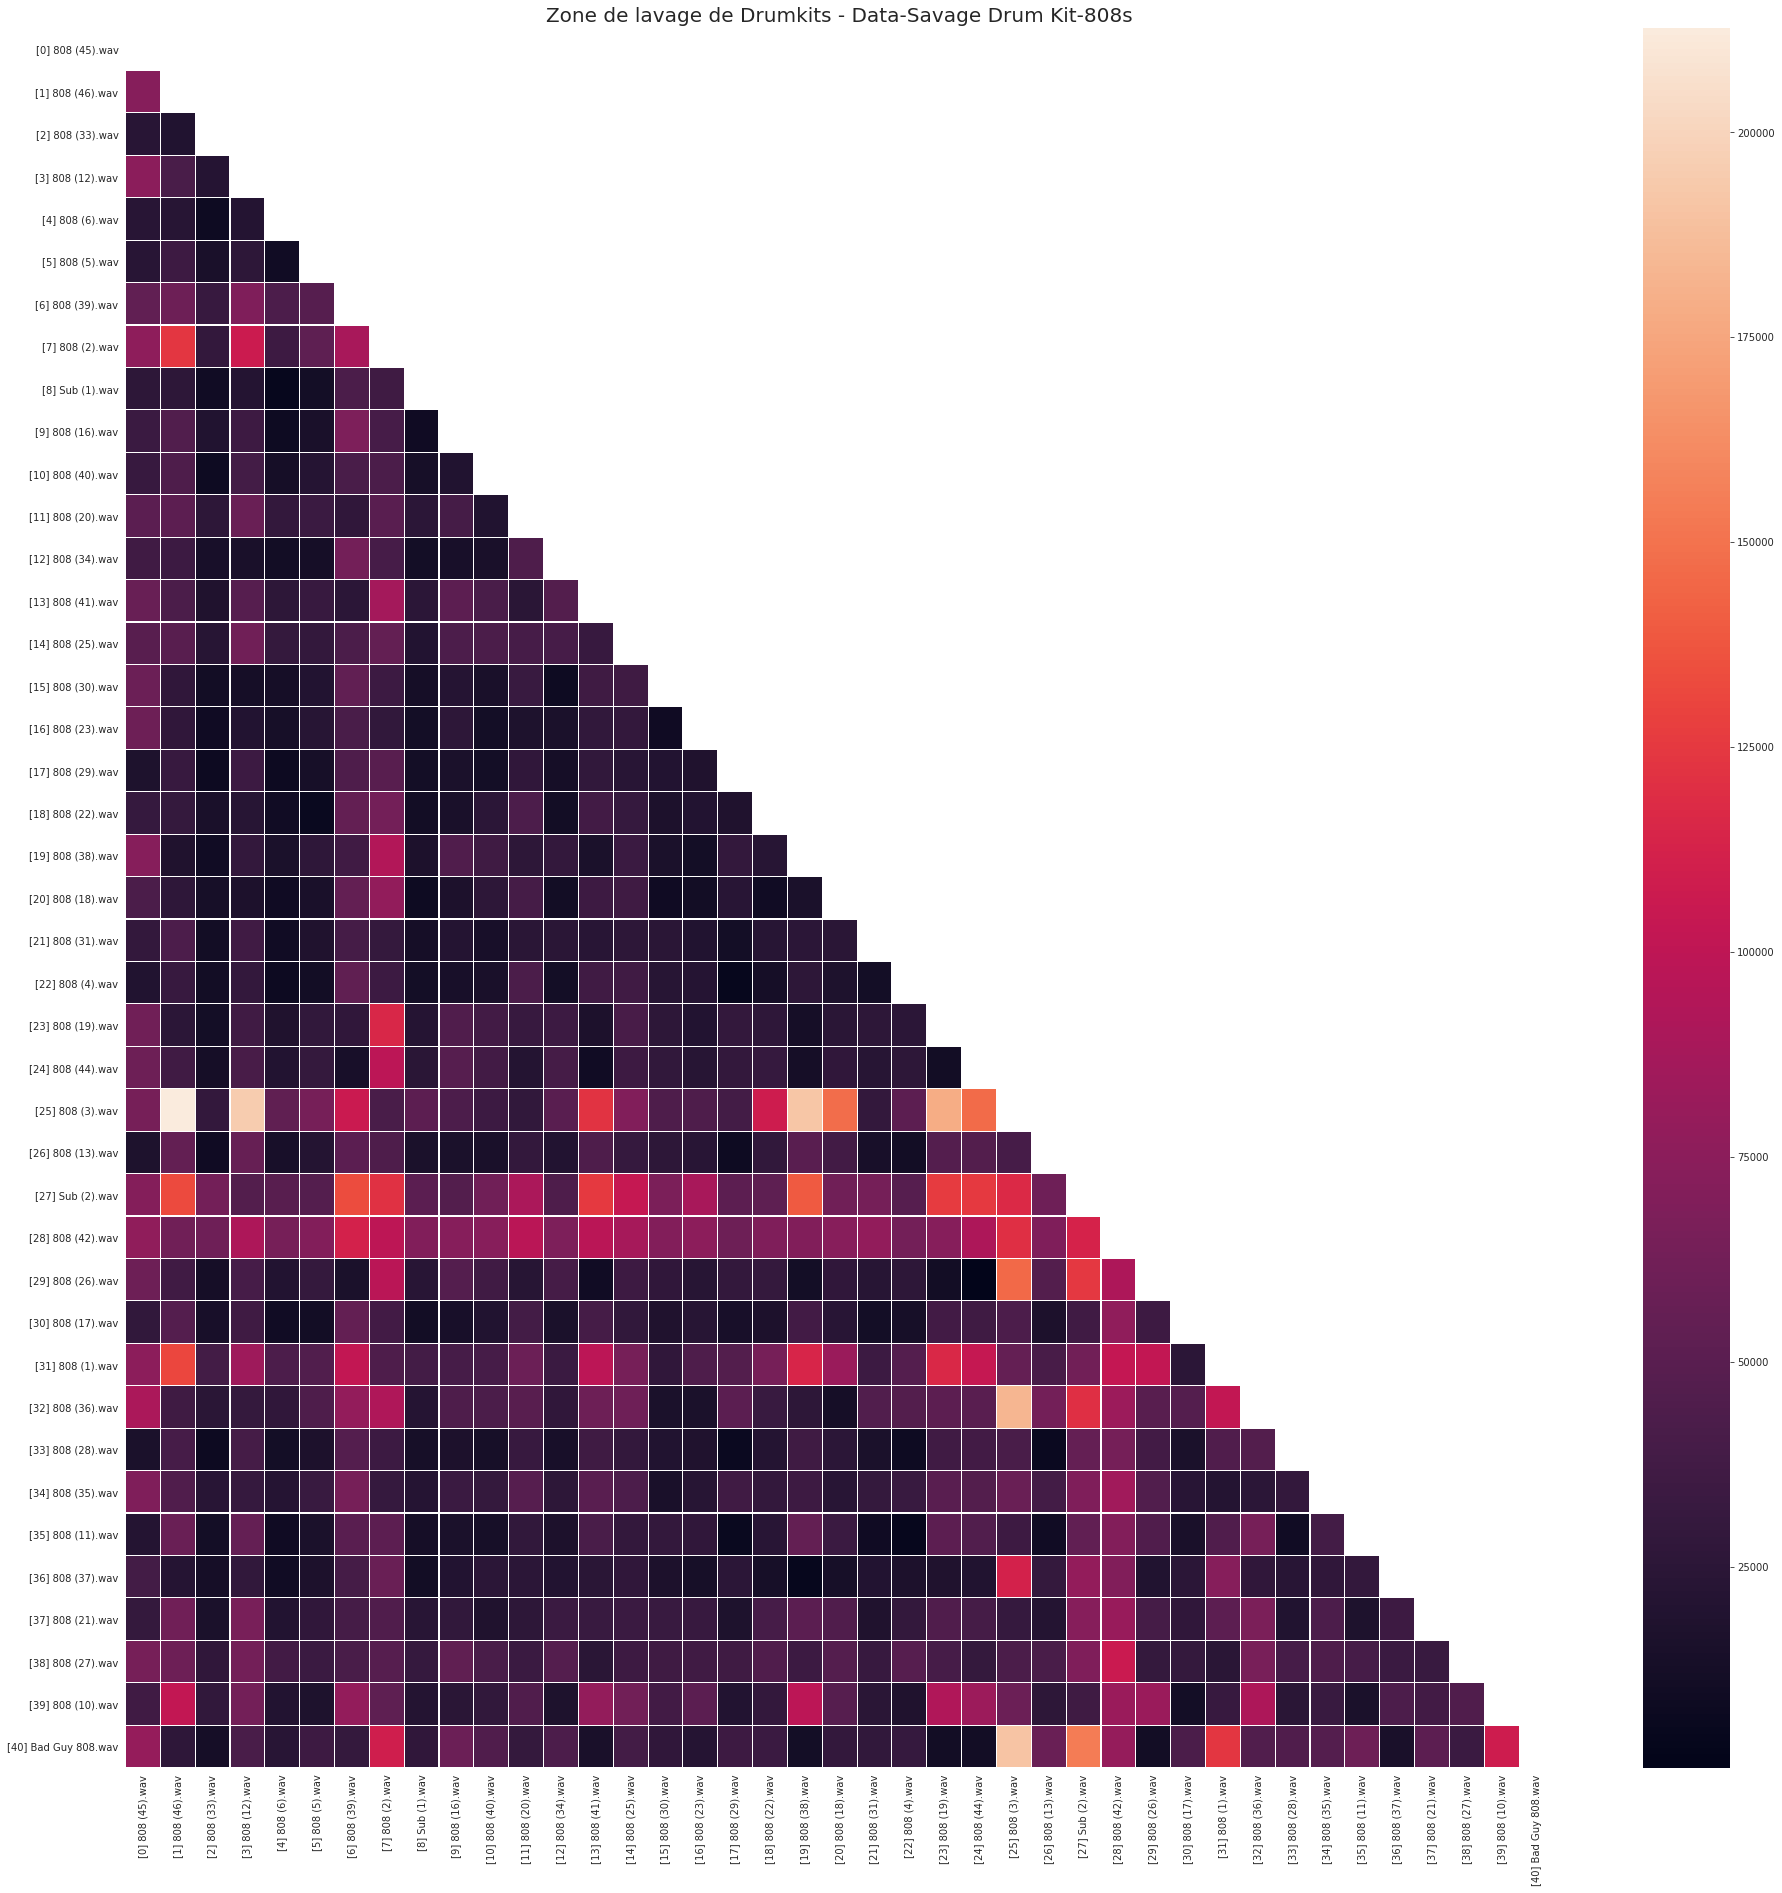

min 489.73588848114014
#              808 (26).wav <-->              808 (44).wav : 489.7 
################################################################################ 17% (2/12) 
### Zone de lavage de Drumkits - Data-Savage Drum Kit-Claps
0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1743
  n_fft, y.shape[-1]


41%41%41%41%41%41%41%41%41%41%41%41%41%41%41%41%41%41%41%41%41%41%41%41%45%45%45%45%45%45%45%45%45%45%45%45%45%45%45%45%45%45%45%45%45%45%45%45%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%54%54%54%54%54%54%54%54%54%54%54%54%54%54%54%54%54%54%54%54%54%54%54%54%58%58%58%58%58%58%58%58%58%58%58%58%58%58%58%58%58%58%58%58%58%58%58%58%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%75%75%75%75%75%75%75%75%75%75%75%75%75%75%75%75%75%75%75%75%75%75%75%75%79%79%79%79%79%79%79%79%79%79%79%79%79%79%79%79%79%79%79%79%79%79%79%79%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%91%91%91%91%91%91%91%91%91%91%91%91%91%91%91%91%91%91%91%91%91%91%91%91%95%95%95%95%95%95%95%95%95%95%95%95%95%95%95%95%95%95%95%95%95%9

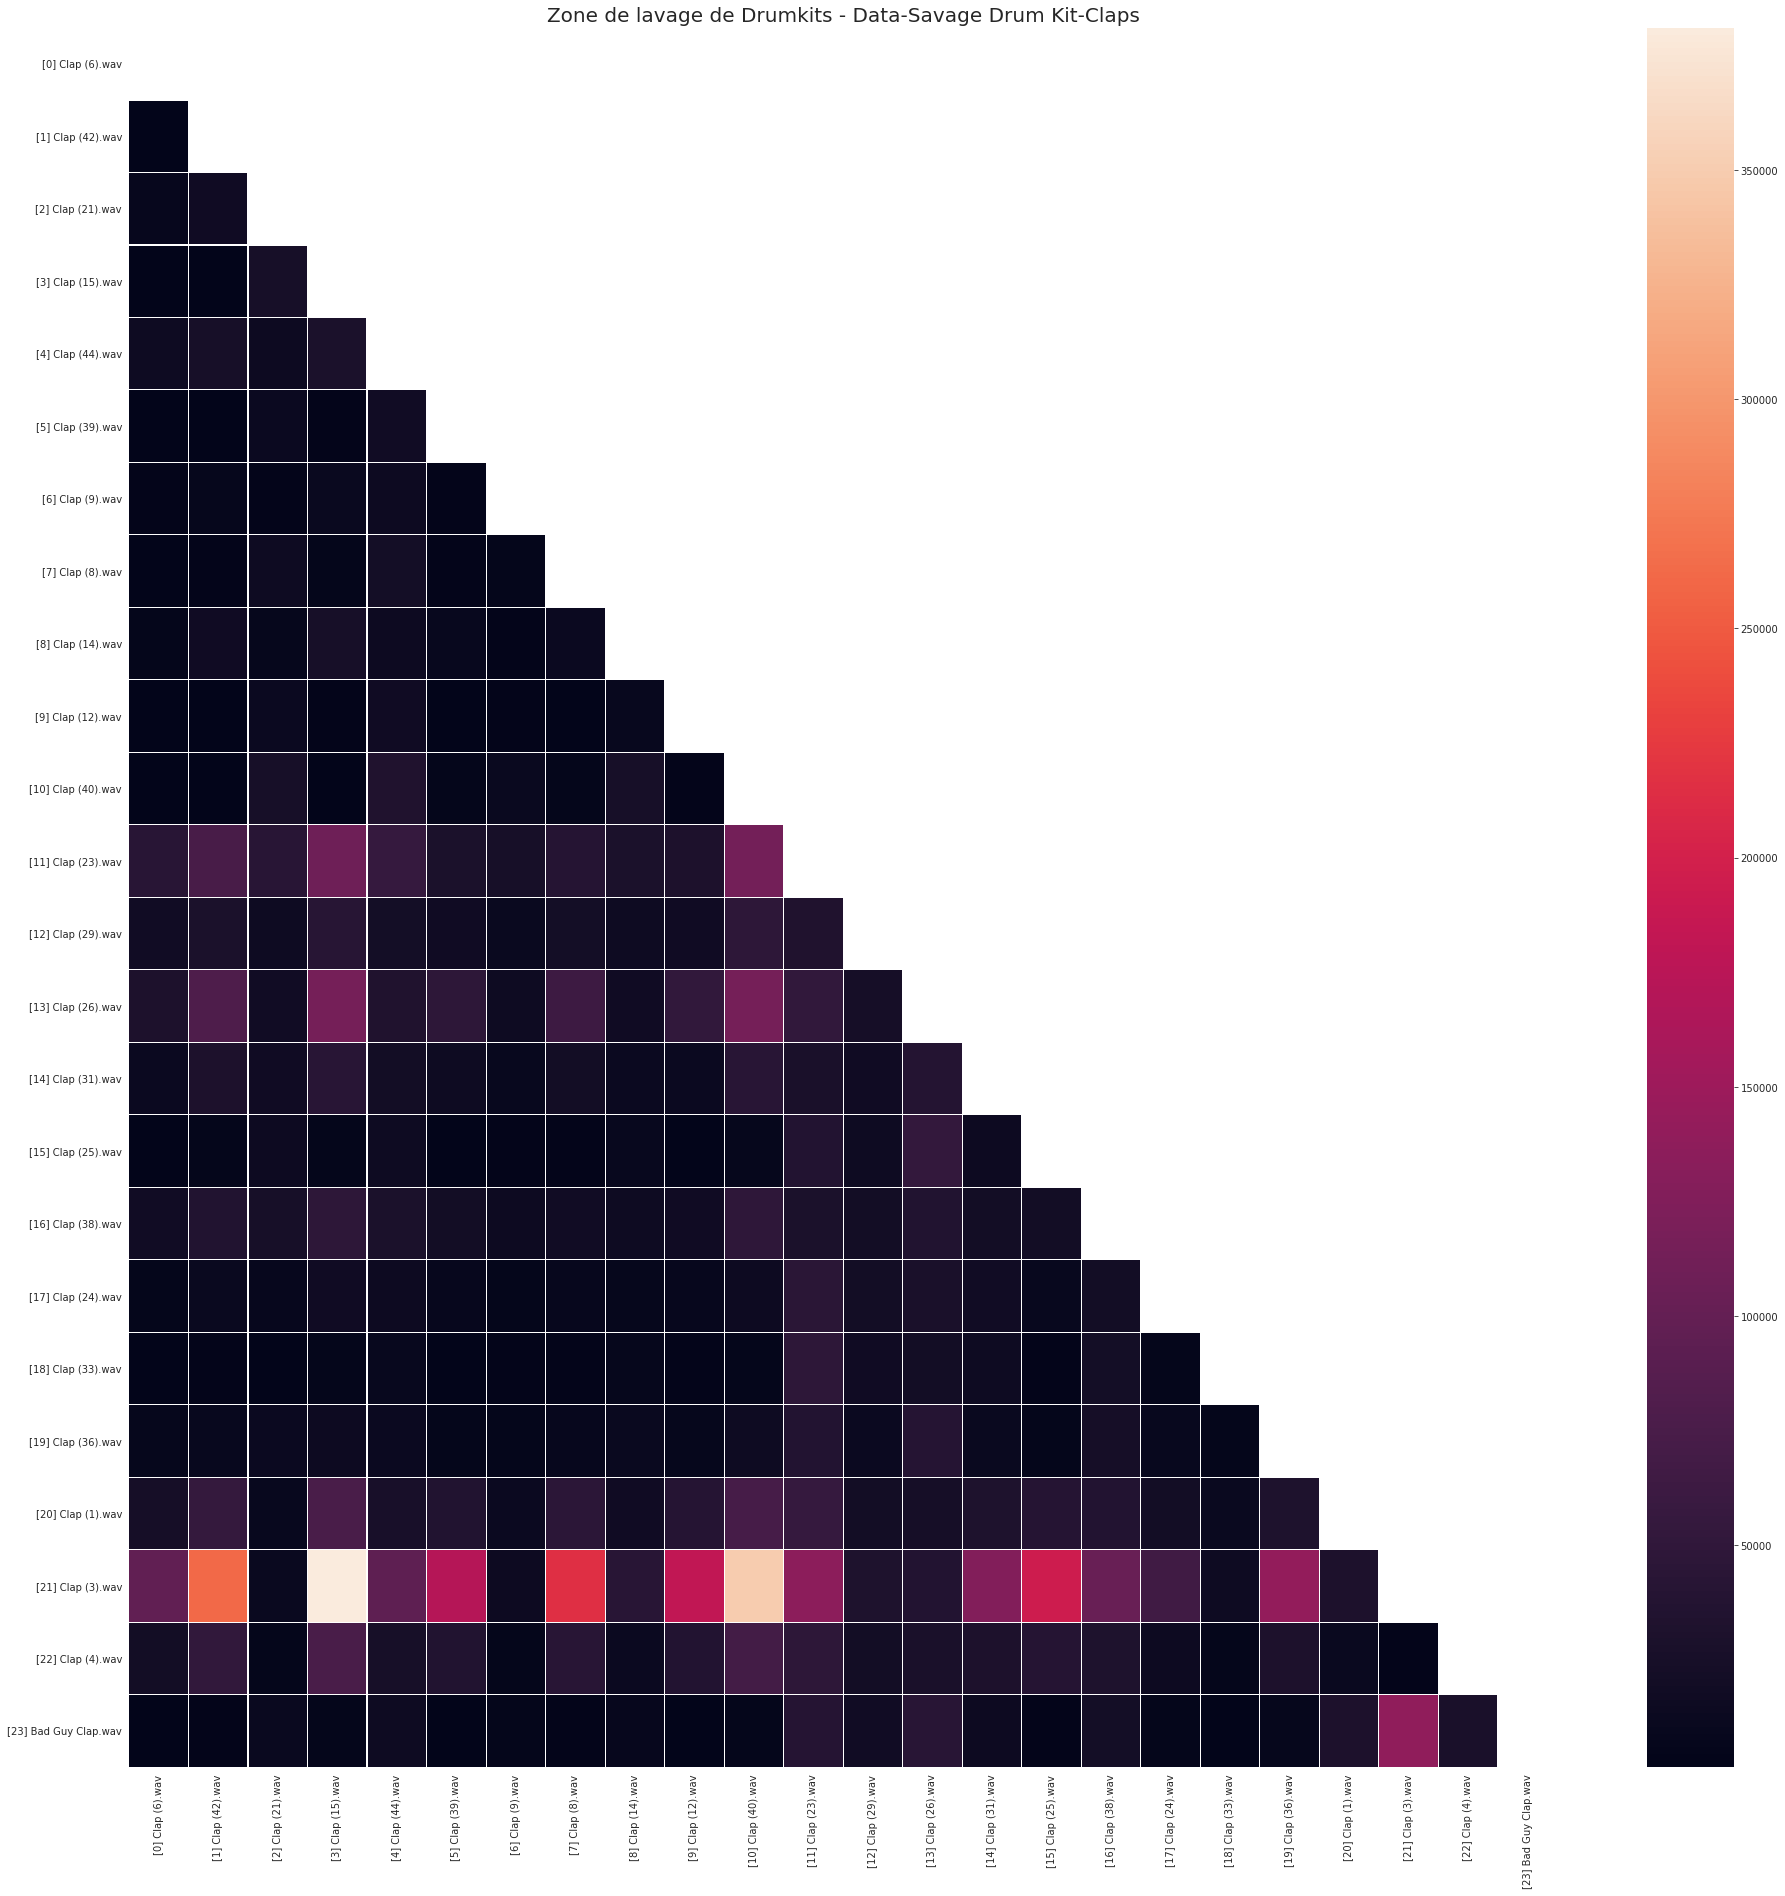

min 1680.627197265625
################################################################################ 25% (3/12) 
### Zone de lavage de Drumkits - Data-Savage Drum Kit-Cymbals
0%0%0%0%0%0%0%0%0%0%0%0%0%0%7%7%7%7%7%7%7%7%7%7%7%7%7%7%

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


error calc distance
14%

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


error calc distance
14%14%14%14%14%14%14%14%14%14%14%14%14%21%21%

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


error calc distance
21%21%21%21%21%21%21%21%21%21%21%21%28%28%

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


error calc distance
28%28%28%28%28%28%28%28%28%28%28%28%35%35%

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


error calc distance
35%35%35%35%35%35%35%35%35%35%35%35%42%42%

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


error calc distance
42%42%42%42%42%42%42%42%42%42%42%42%50%50%

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


error calc distance
50%50%50%50%50%50%50%50%50%50%50%50%57%57%

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


error calc distance
57%57%57%57%57%57%57%57%57%57%57%57%64%64%

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


error calc distance
64%64%64%64%64%64%64%64%64%64%64%64%71%71%

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


error calc distance
71%71%71%71%71%71%71%71%71%71%71%71%78%78%

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


error calc distance
78%78%78%78%78%78%78%78%78%78%78%78%85%85%

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


error calc distance
85%85%85%85%85%85%85%85%85%85%85%85%92%92%

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


error calc distance
92%92%92%92%92%92%92%92%92%92%92%92%

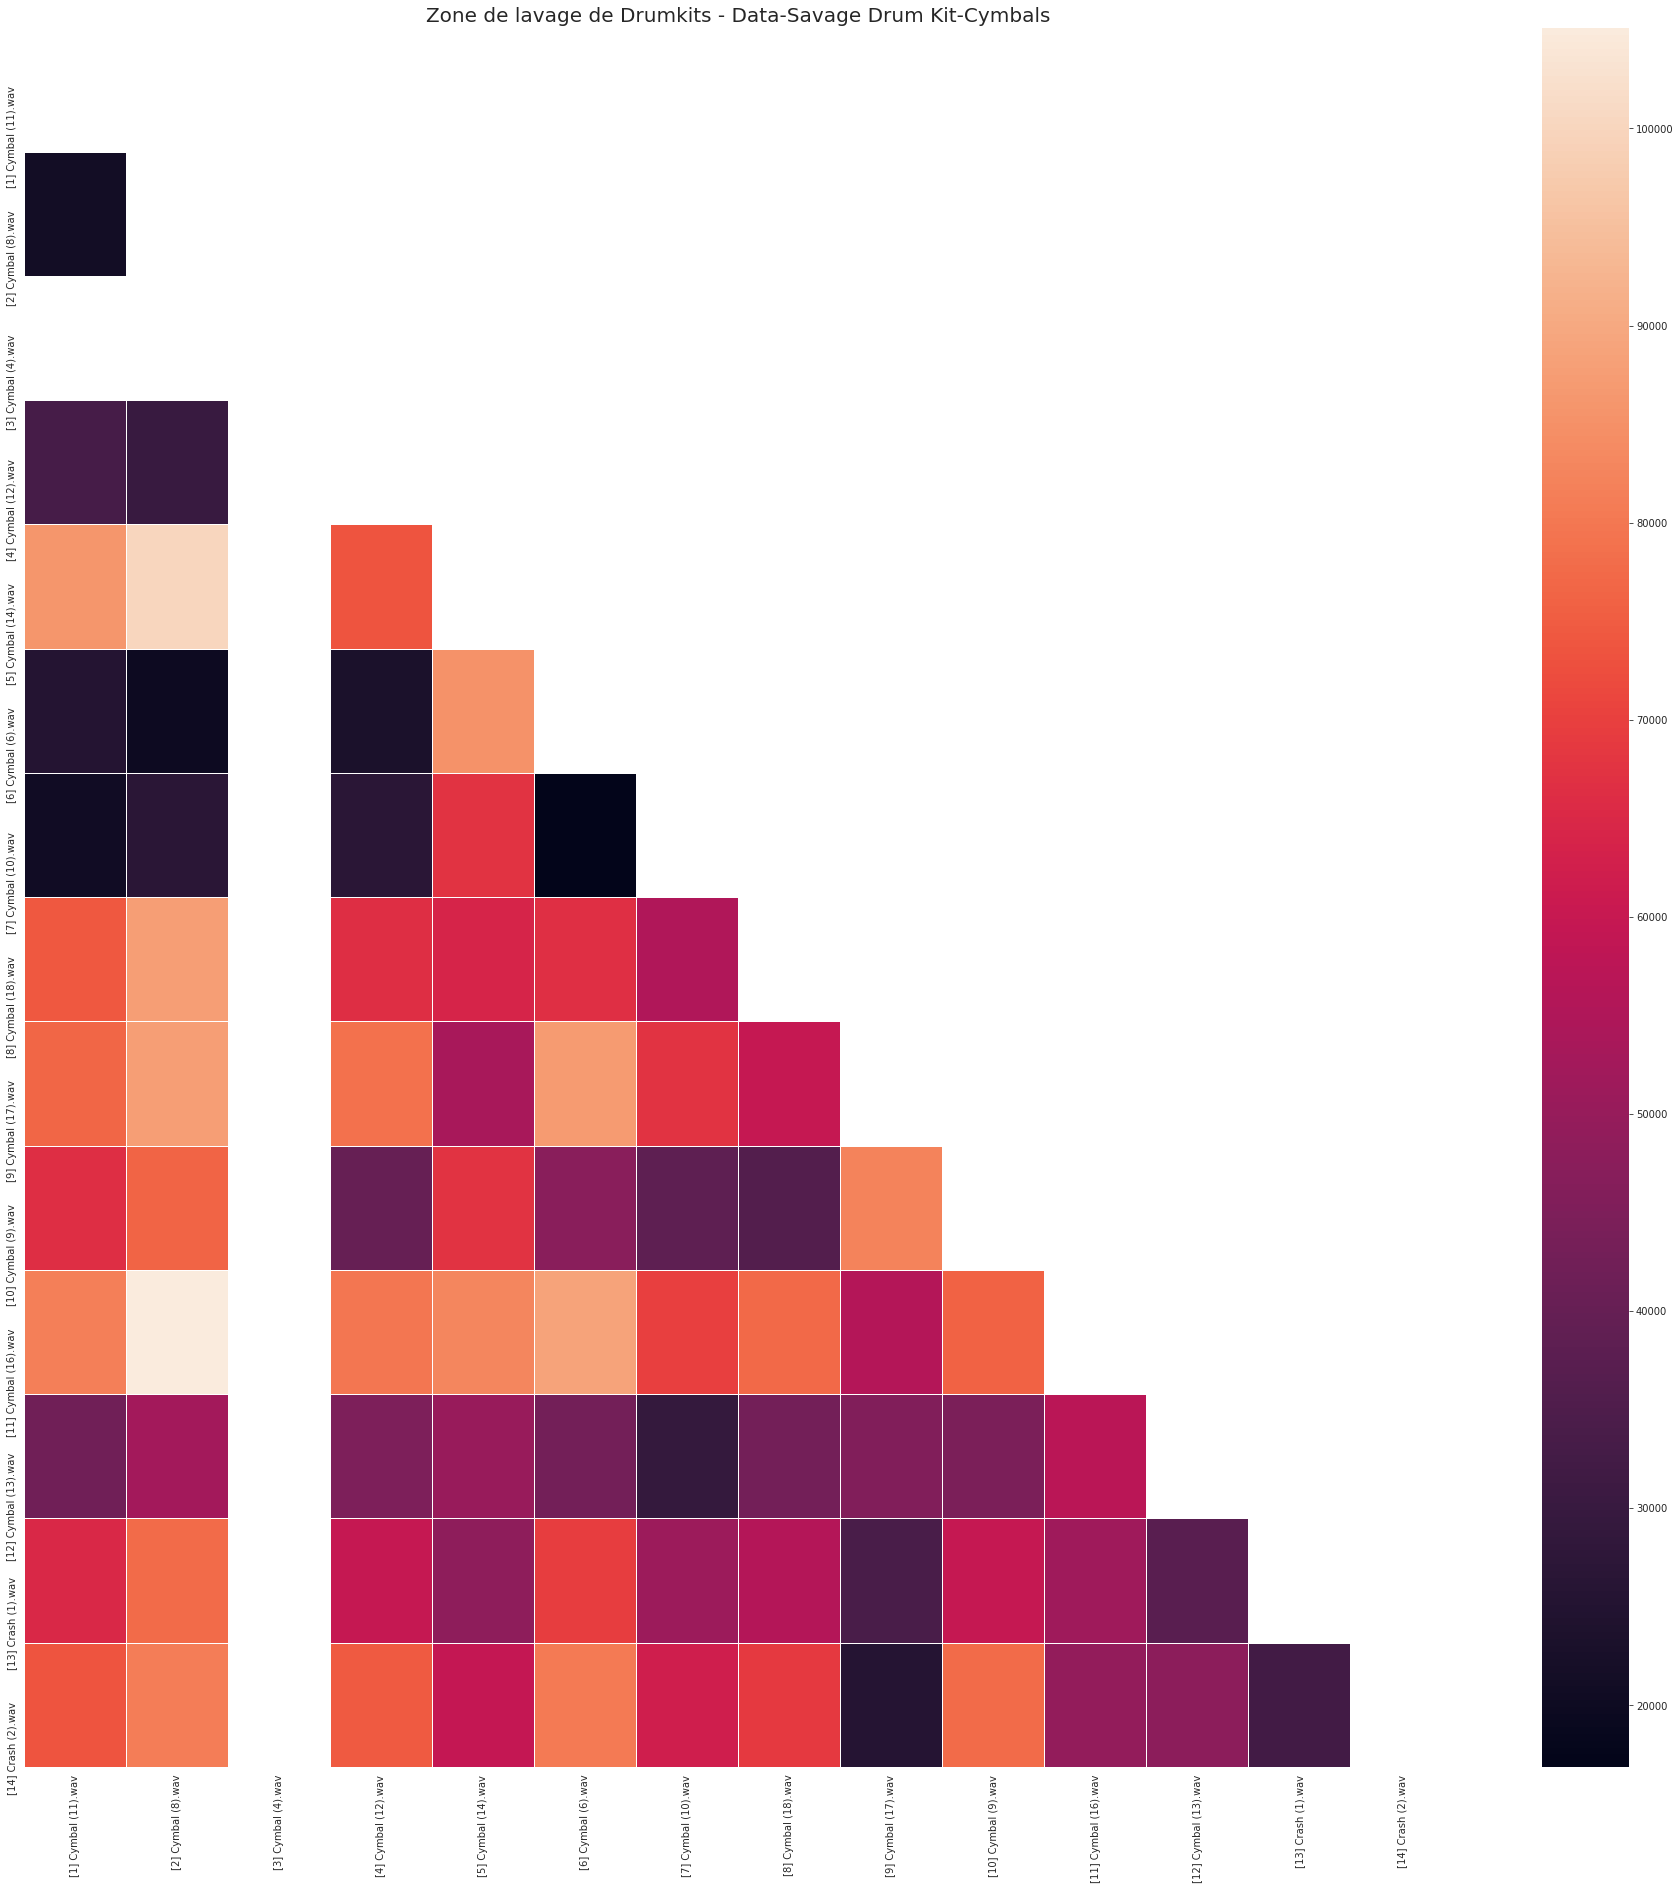

min 16847.511474609375
################################################################################ 33% (4/12) 
### Zone de lavage de Drumkits - Data-Savage Drum Kit-FX
0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%33%33%33%33%33%33

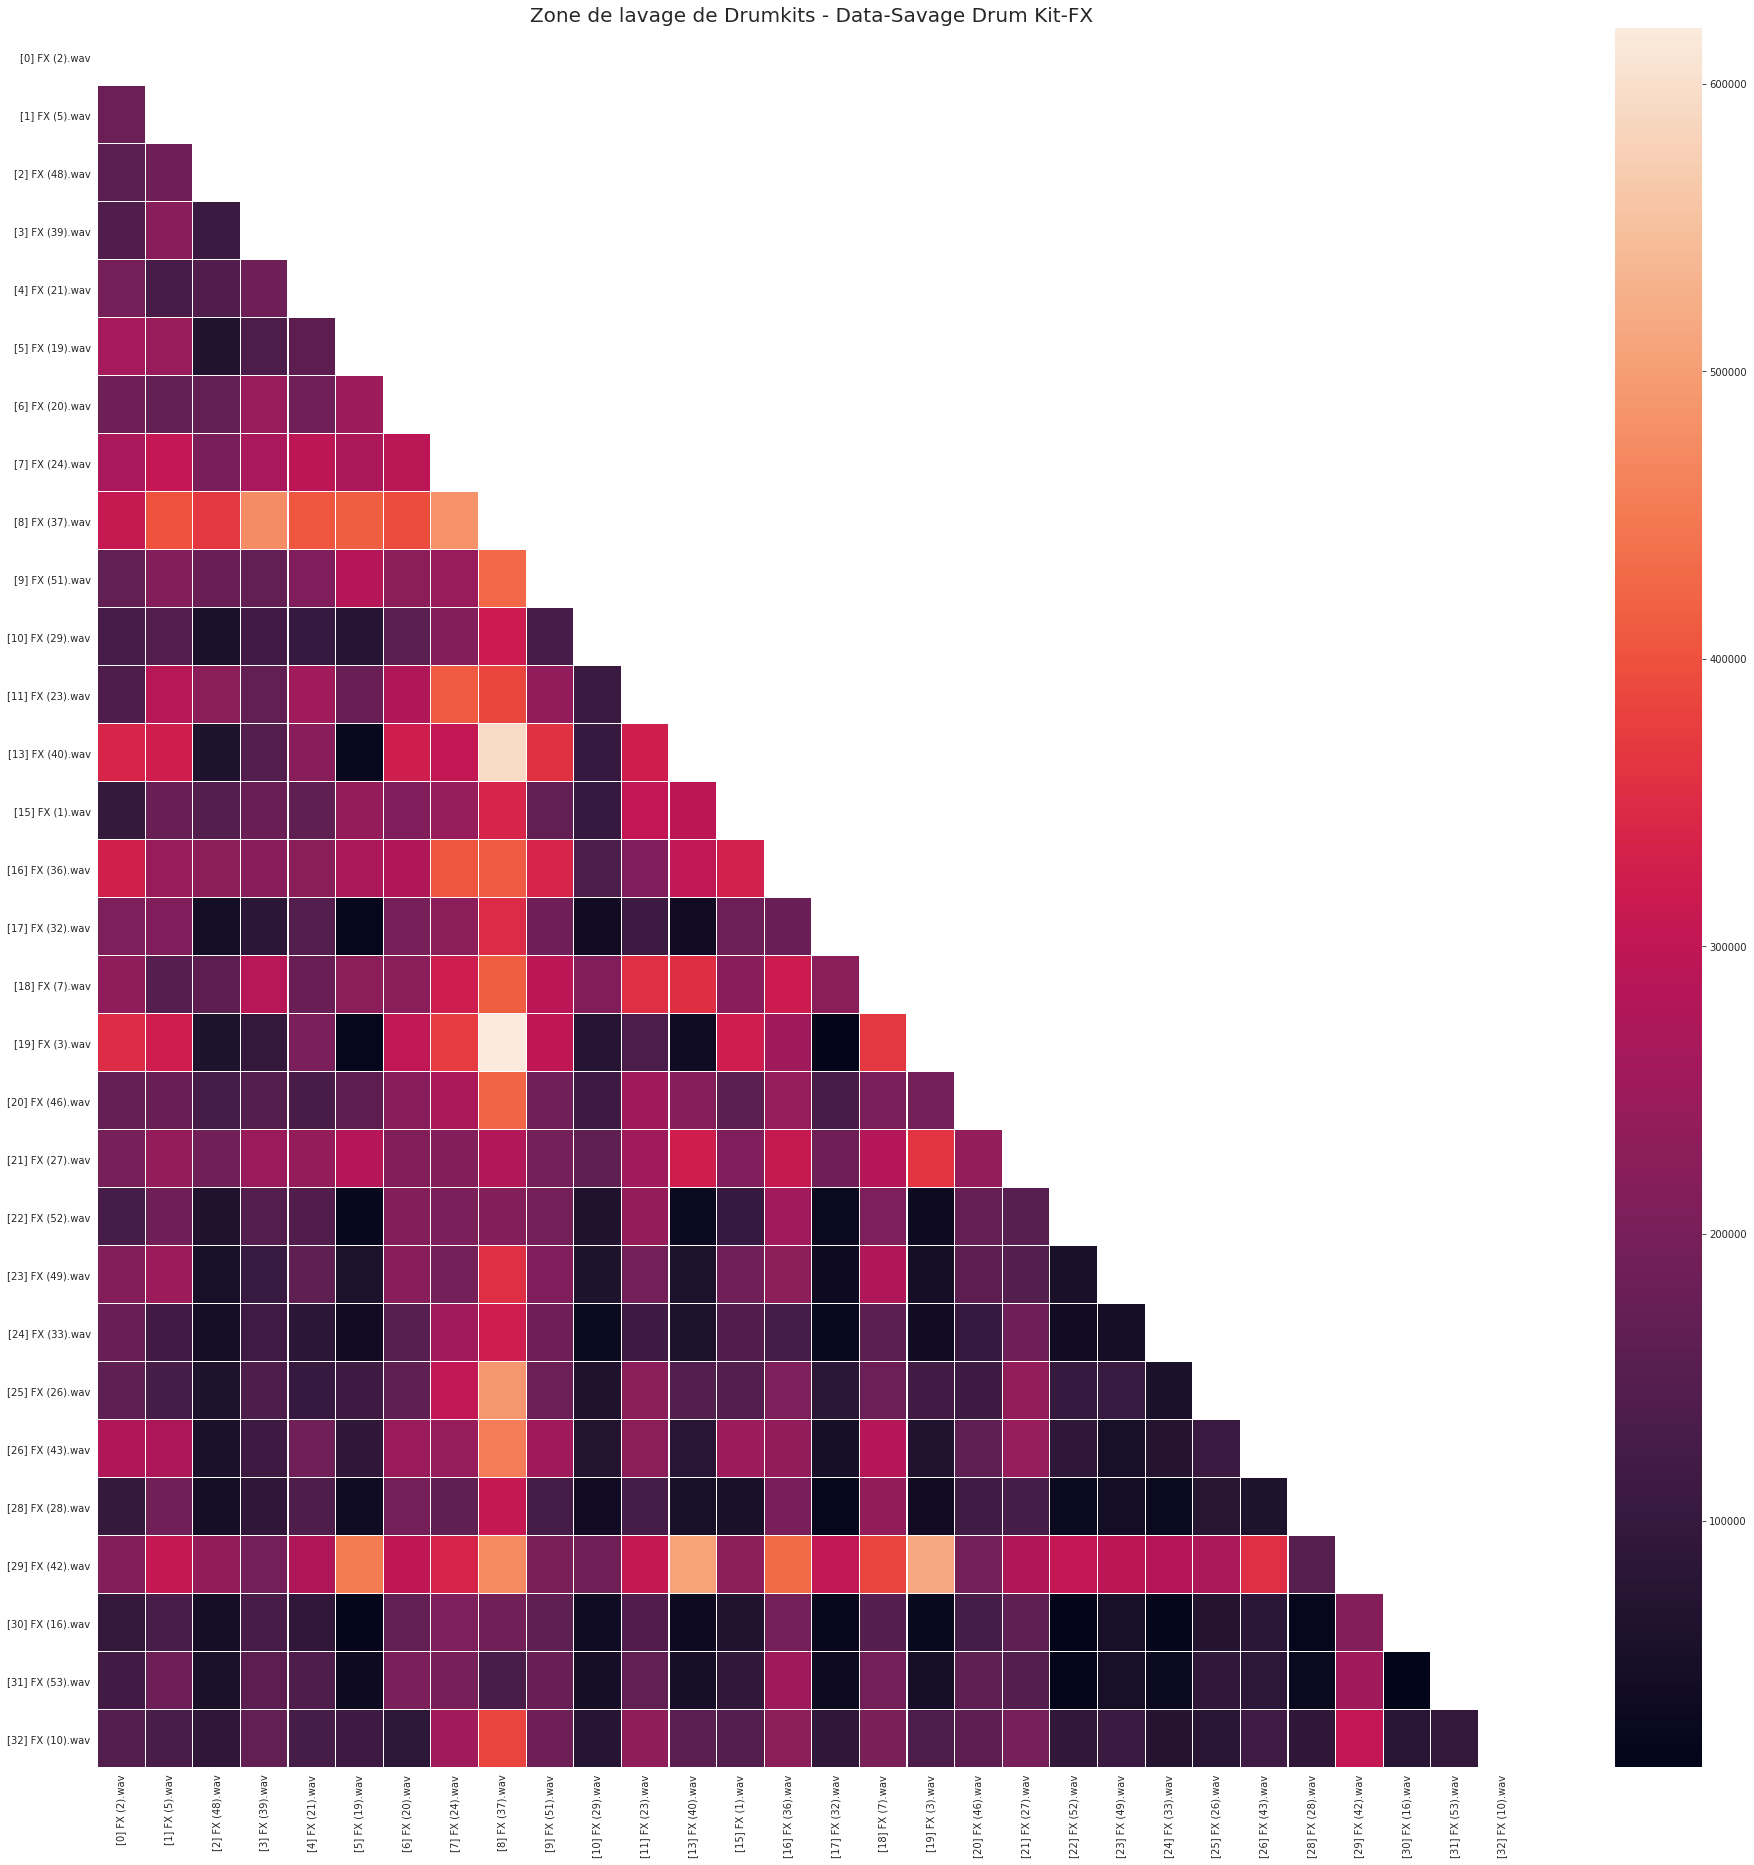

min 14276.204498291016
################################################################################ 42% (5/12) 
### Zone de lavage de Drumkits - Data-Savage Drum Kit-Hi Hats
0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1407
  n_fft, y.shape[-1]


6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1764
  n_fft, y.shape[-1]


13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1737
  n_fft, y.shape[-1]


33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]


40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%60%60%60%60%60%60%60%60%60%60%60%60%60%60%60%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1711
  n_fft, y.shape[-1]


73%73%73%73%73%73%73%73%73%73%73%73%73%73%73%80%80%80%80%80%80%80%80%80%80%80%80%80%80%80%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1678
  n_fft, y.shape[-1]


86%86%86%86%86%86%86%86%86%86%86%86%86%86%86%93%93%93%93%93%93%93%93%93%93%93%93%93%93%93%

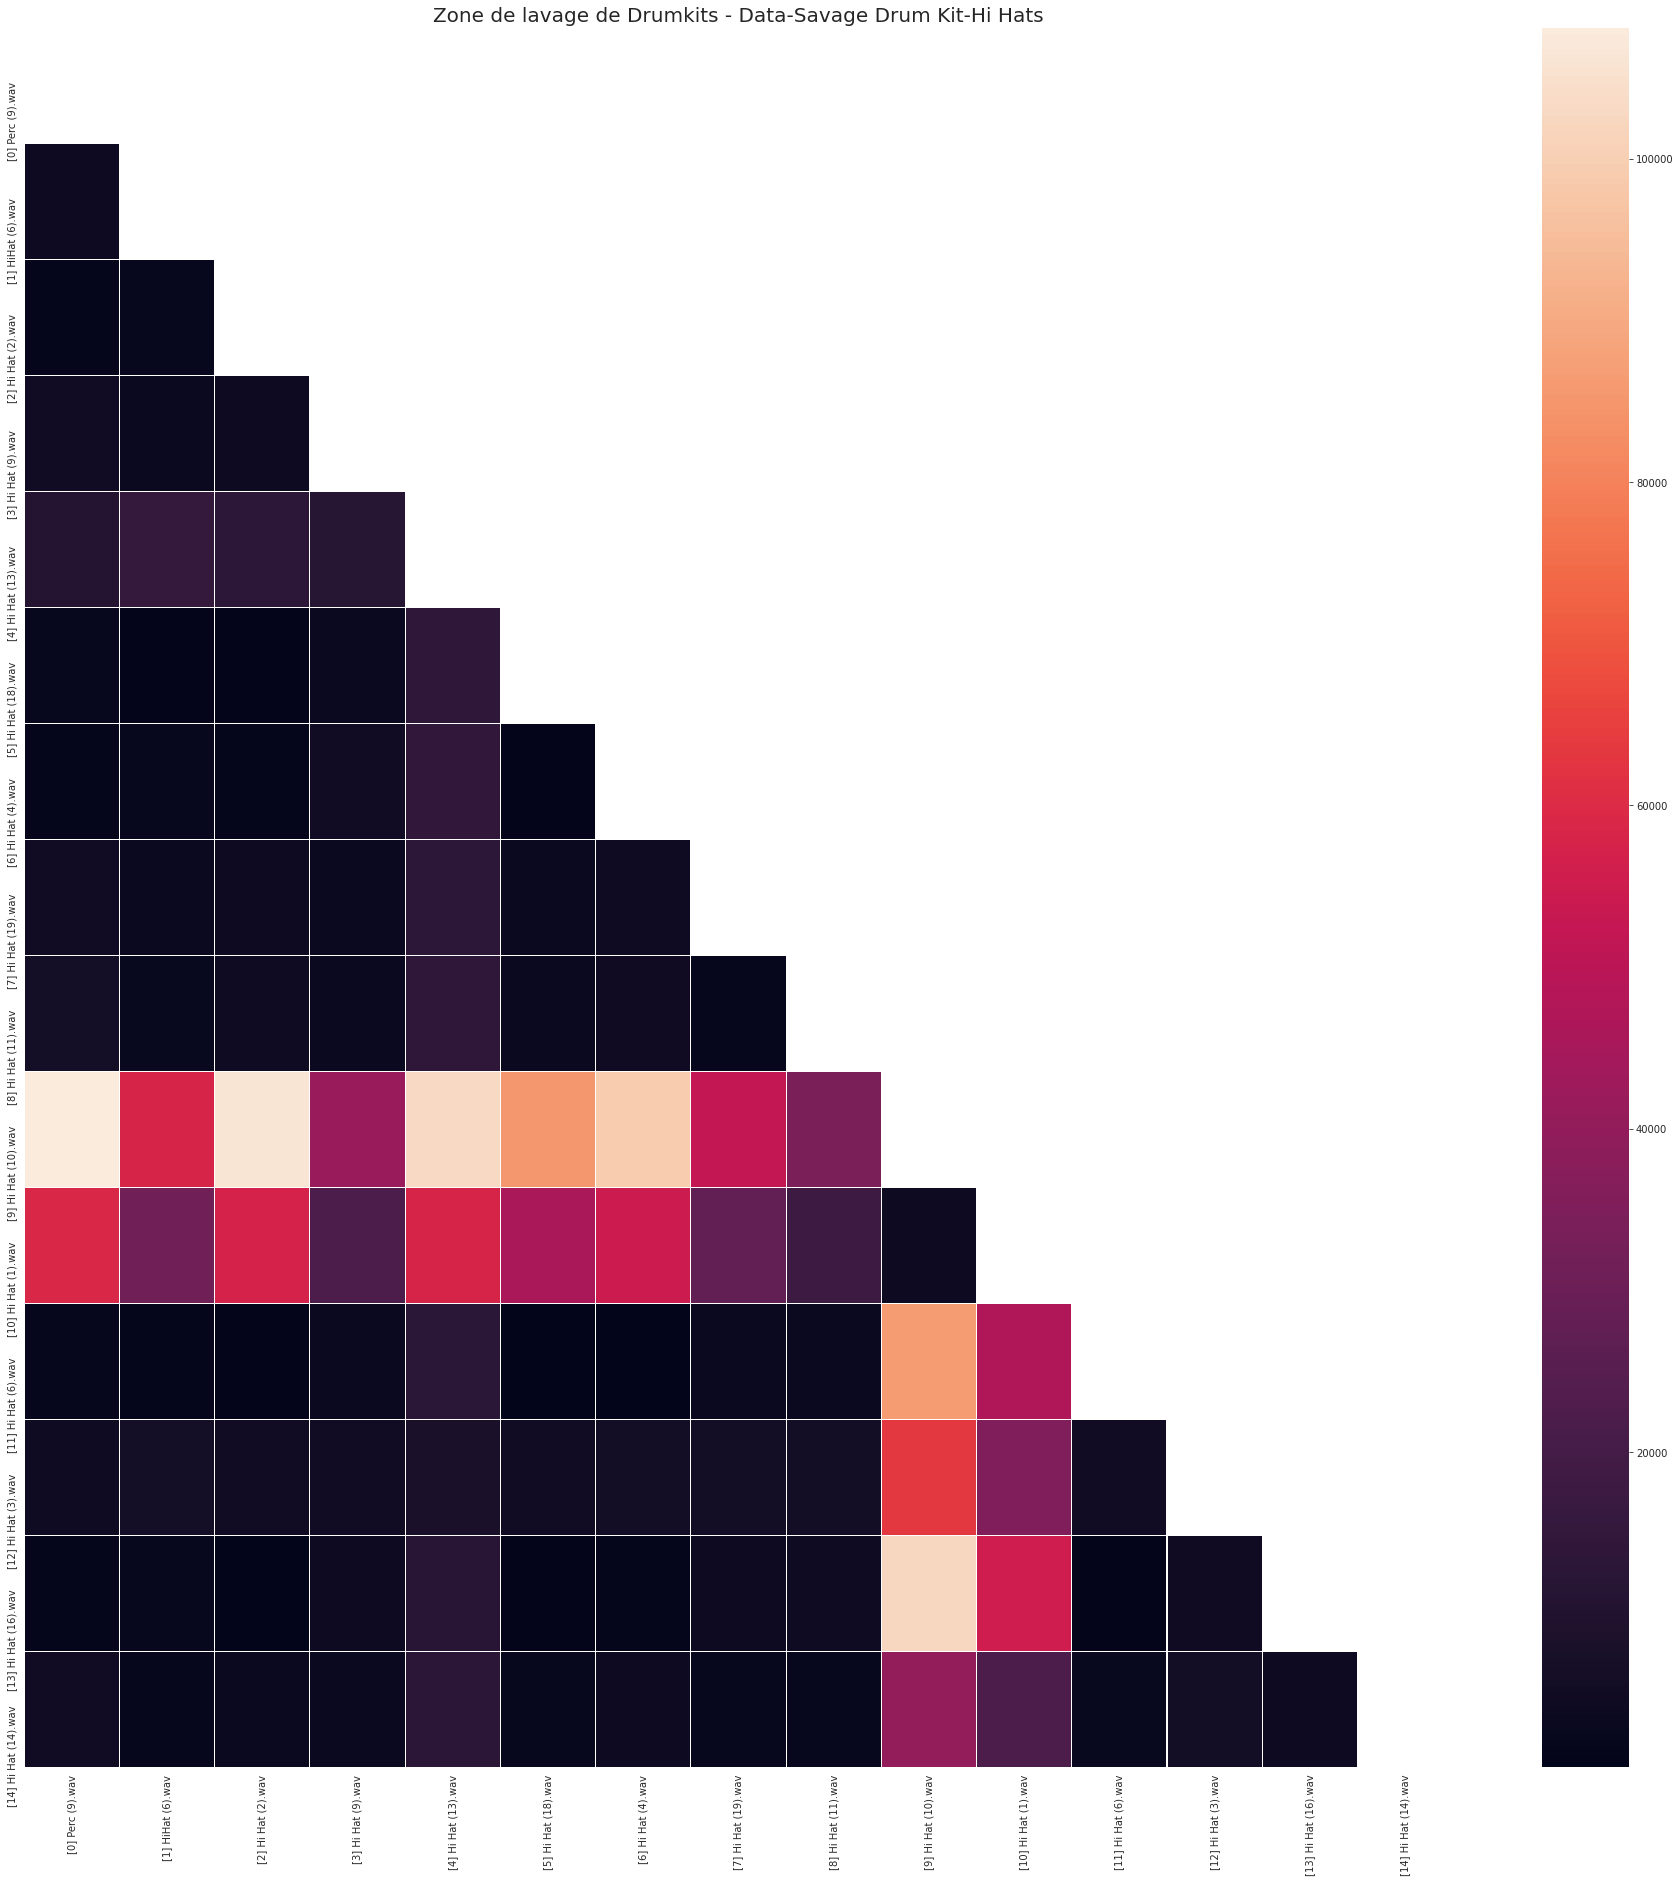

min 500.49951934814453
#           Hi Hat (18).wav <-->            Hi Hat (2).wav : 1168.0 
#            Hi Hat (4).wav <-->           Hi Hat (18).wav : 1127.0 
#            Hi Hat (6).wav <-->            Hi Hat (2).wav : 1107.9 
#            Hi Hat (6).wav <-->           Hi Hat (18).wav : 718.8 
#            Hi Hat (6).wav <-->            Hi Hat (4).wav : 916.3 
#           Hi Hat (16).wav <-->            Hi Hat (2).wav : 500.5 
#           Hi Hat (16).wav <-->           Hi Hat (18).wav : 1106.1 
#           Hi Hat (16).wav <-->            Hi Hat (6).wav : 1063.0 
################################################################################ 50% (6/12) 
### Zone de lavage de Drumkits - Data-Savage Drum Kit-Hits
0%0%0%0%0%0%16%16%16%16%16%16%33%33%33%33%33%33%50%50%50%50%50%50%66%66%66%66%66%66%83%83%83%83%83%83%

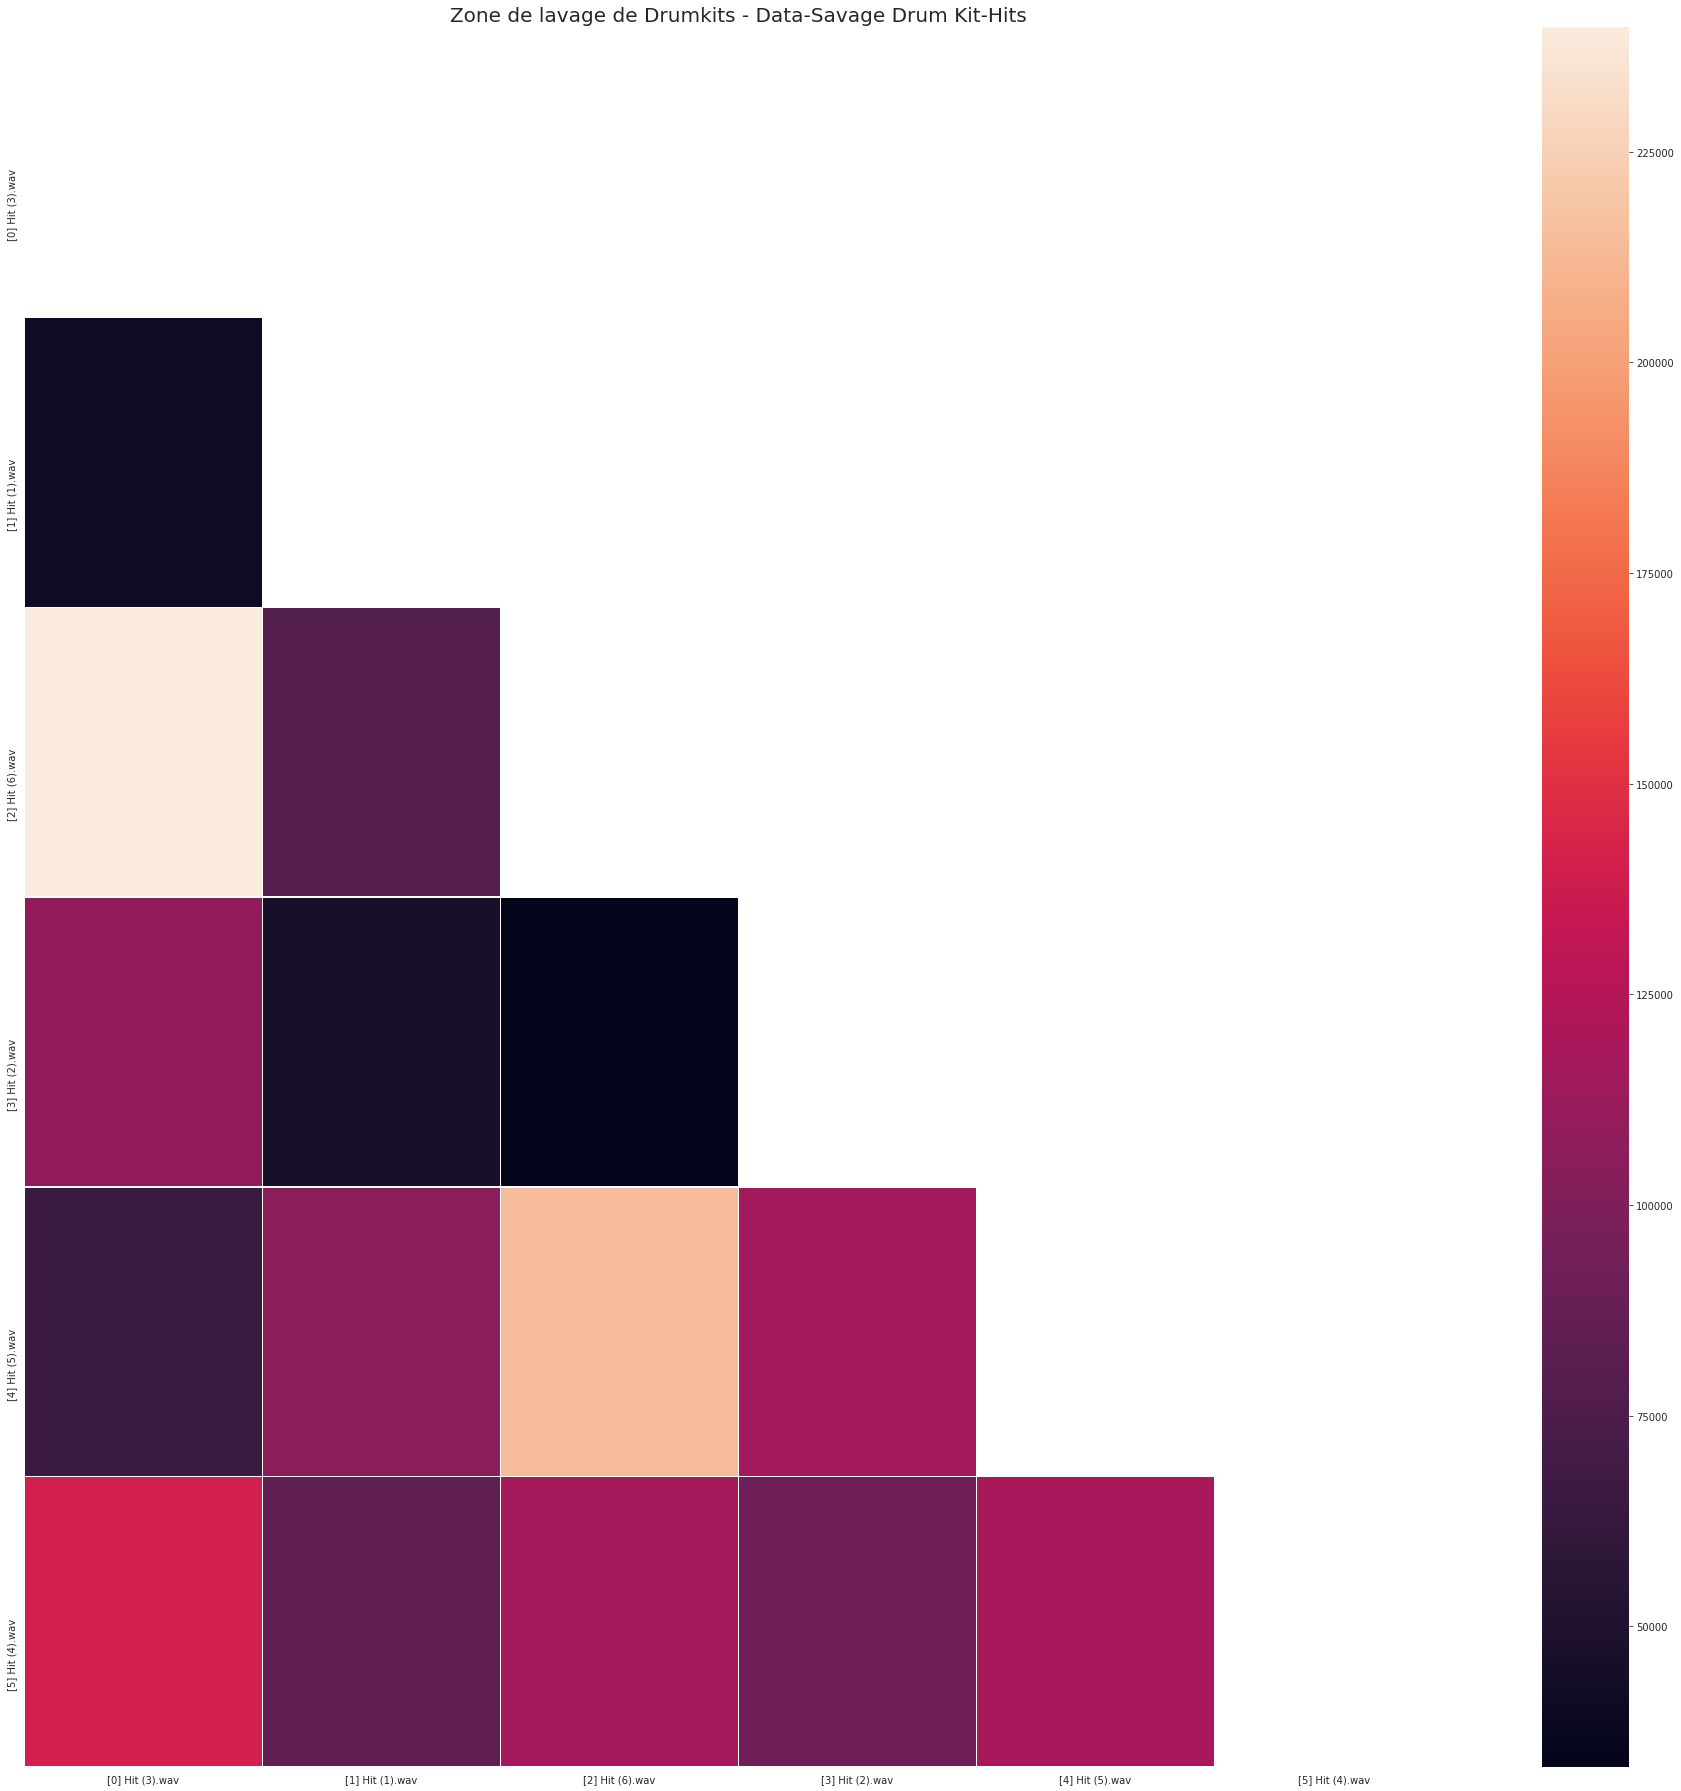

min 33320.20287322998
################################################################################ 58% (7/12) 
### Zone de lavage de Drumkits - Data-Savage Drum Kit-Kicks
0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%4%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%8%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1793
  n_fft, y.shape[-1]


17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%17%21%21%21%21%21%21%21%21%21%21%21%21%21%21%21%21%21%21%21%21%21%21%21%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%34%34%34%34%34%34%34%34%34%34%34%34%34%34%34%34%34%34%34%34%34%34%34%39%39%39%39%39%39%39%39%39%39%39%39%39%39%39%39%39%39%39%39%39%39%39%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%47%47%47%47%47%47%47%47%47%47%47%47%47%47%47%47%47%47%47%47%47%47%47%52%52%52%52%52%52%52%52%52%52%52%52%52%52%52%52%52%52%52%52%52%52%52%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%60%60%60%60%60%60%60%60%60%60%60%60%60%60%60%60%60%60%60%60%60%60%60%65%65%65%65%65%65%65%65%65%65%65%65%65%65%65%65%65%65%65%65%65%65%65%69%69%69%69%69%69%69%69%69%69%69%69%69%69%69%69%69%69%69%69%69%69%69%73%73%73%73%73%73%73%73%73%73%73%73%73%73%73%73%73%73%73%73%73%73%73%78%78%78%78%78%78%78%78%78%78%78%7

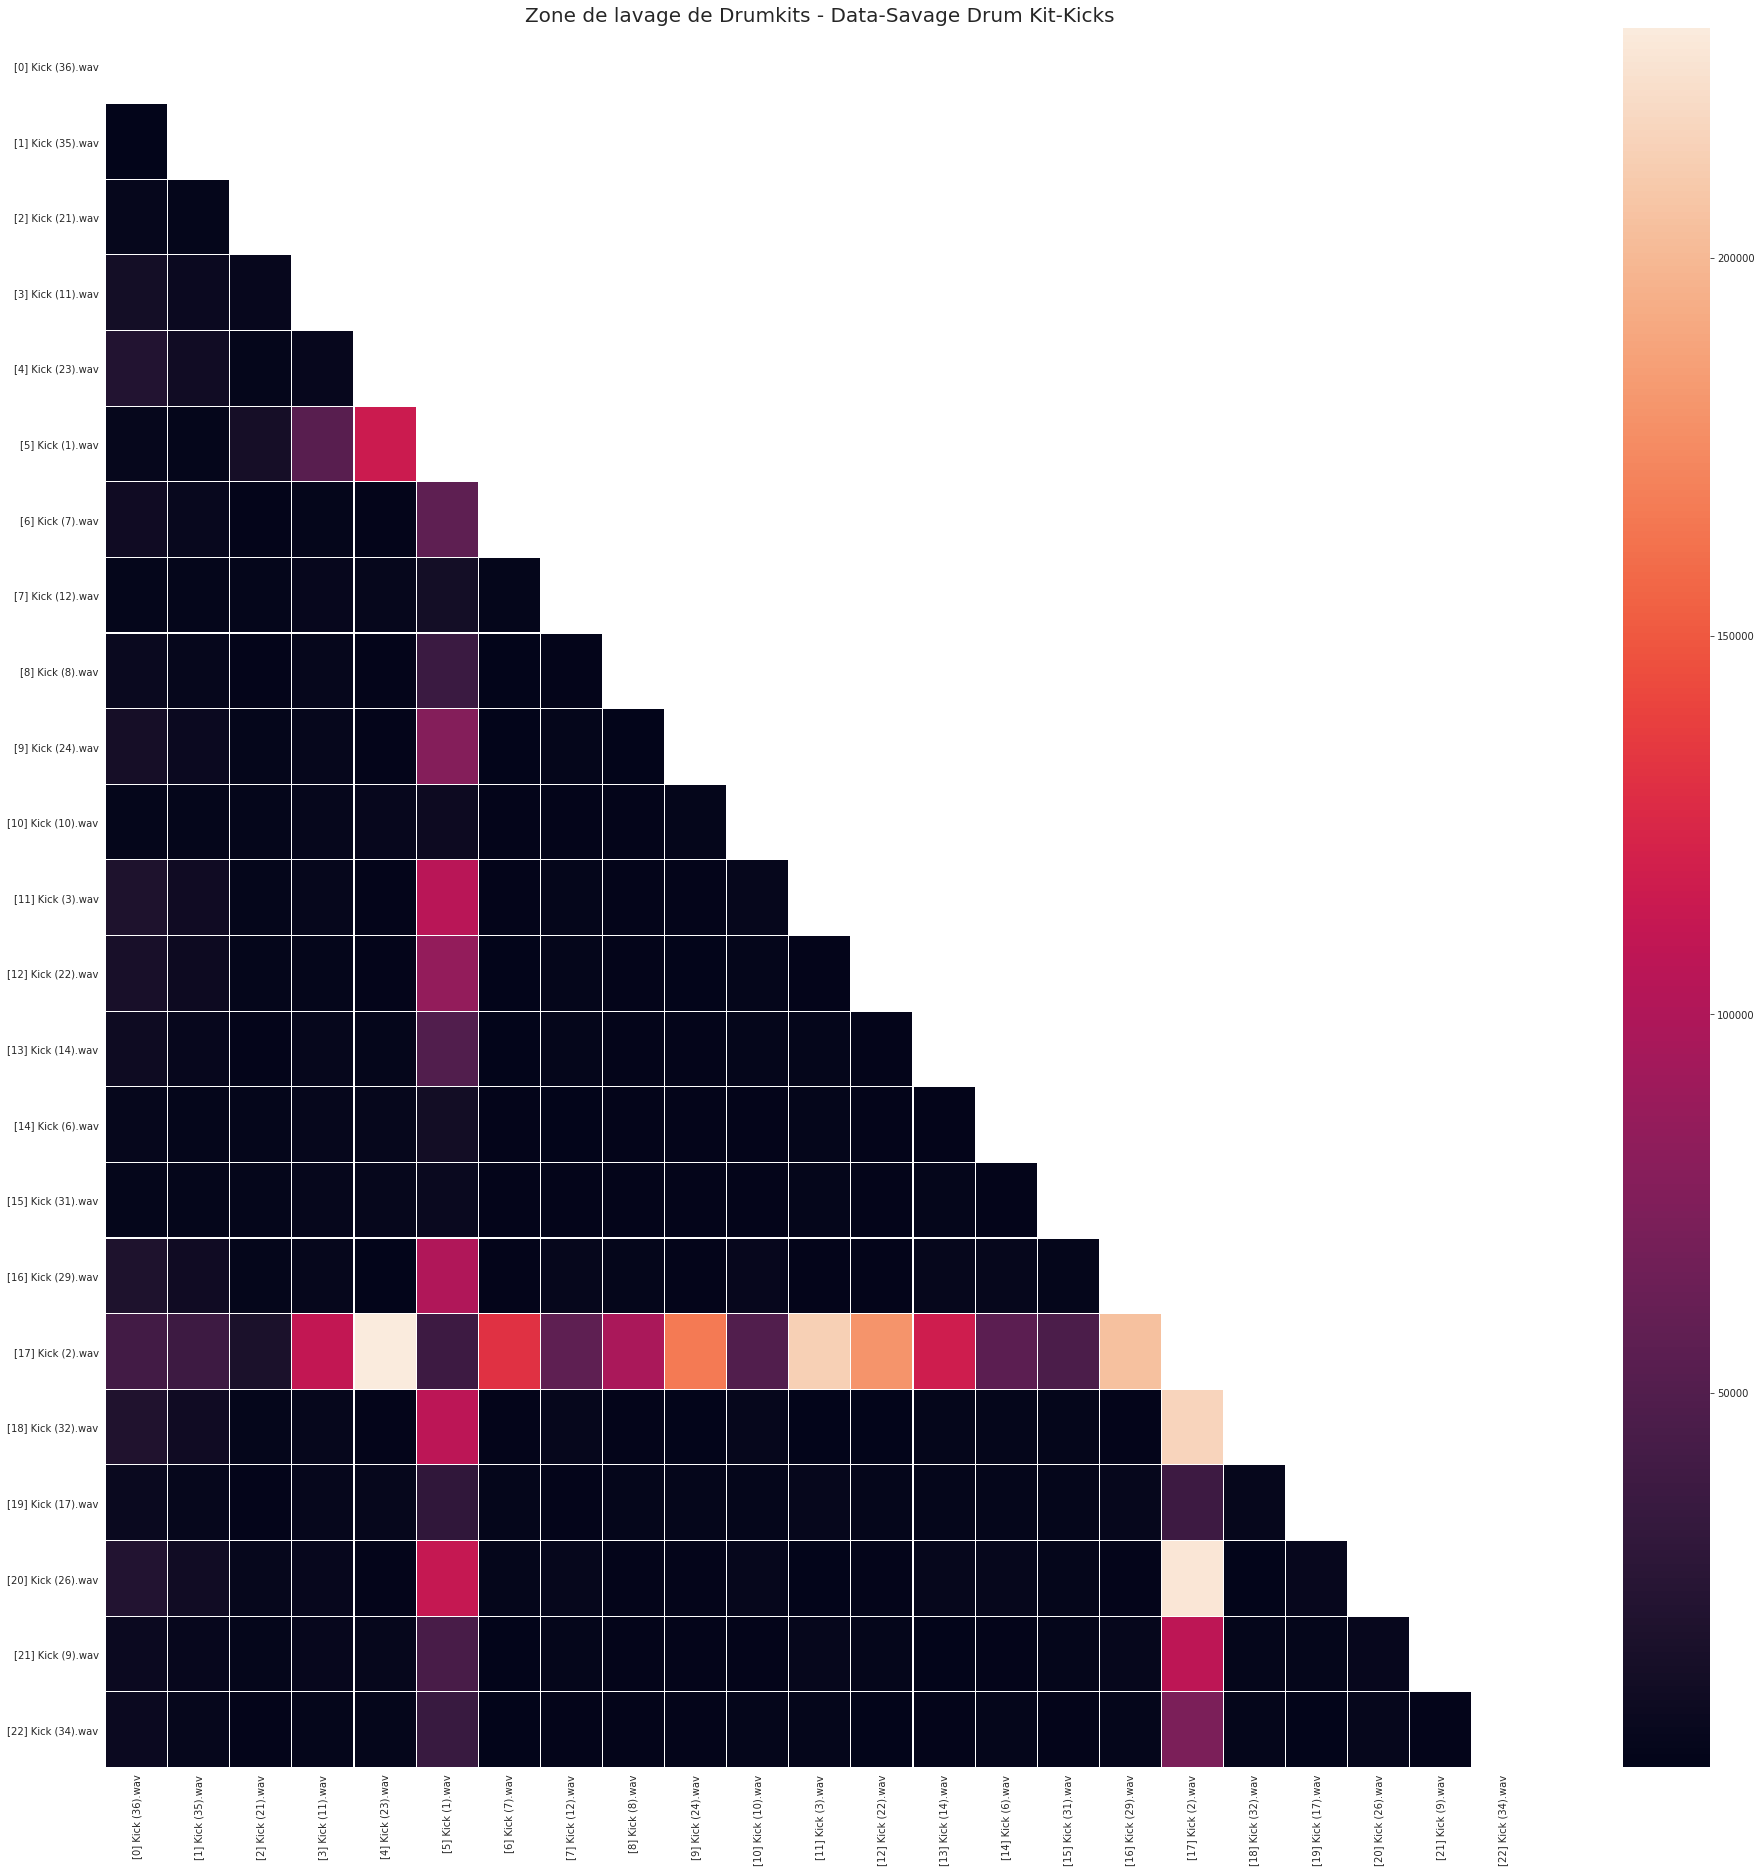

min 457.335711479187
#             Kick (35).wav <-->             Kick (36).wav : 1085.5 
#             Kick (24).wav <-->              Kick (7).wav : 1058.0 
#             Kick (22).wav <-->              Kick (7).wav : 949.0 
#             Kick (22).wav <-->             Kick (24).wav : 838.0 
#             Kick (14).wav <-->              Kick (7).wav : 457.3 
#             Kick (32).wav <-->              Kick (3).wav : 1175.4 
#             Kick (26).wav <-->              Kick (3).wav : 879.3 
#             Kick (26).wav <-->             Kick (32).wav : 1010.2 
#              Kick (9).wav <-->             Kick (14).wav : 1233.2 
################################################################################ 67% (8/12) 
### Zone de lavage de Drumkits - Data-Savage Drum Kit-Open Hats
0%0%0%0%0%0%0%0%0%0%0%0%8%8%8%8%8%8%8%8%8%8%8%8%16%16%16%16%16%16%16%16%16%16%16%16%25%25%25%25%25%25%25%25%25%25%25%25%33%33%33%33%33%33%33%33%33%33%33%33%41%41%41%41%41%41%41%41%41%41%41%41%50%50%50%50%5

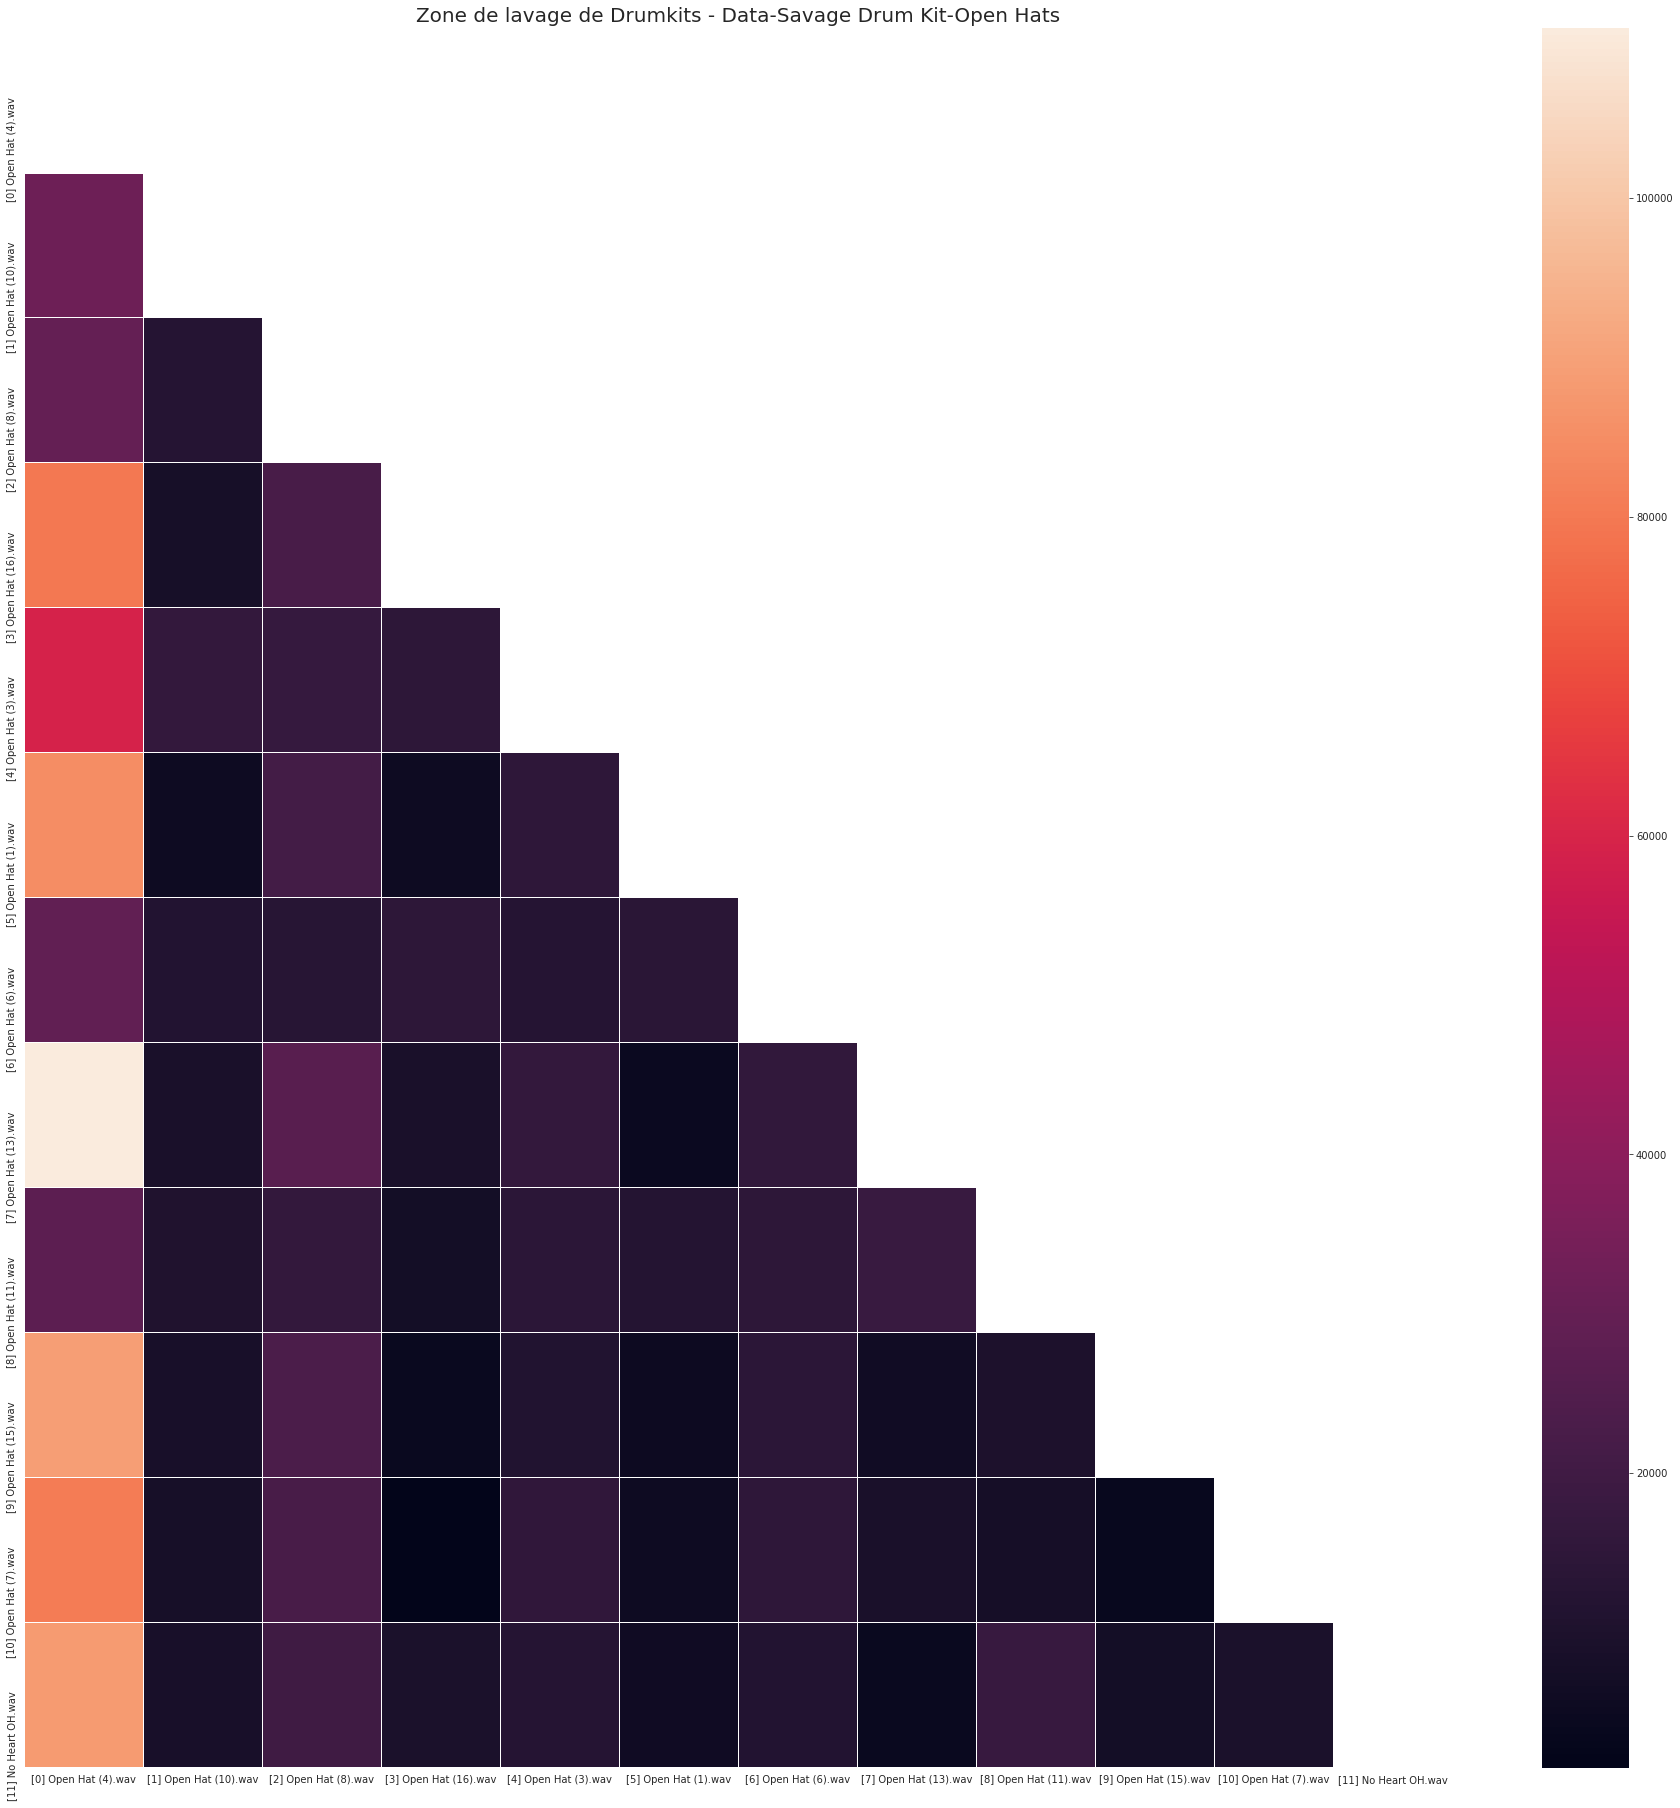

min 1534.0782089233398
################################################################################ 75% (9/12) 
### Zone de lavage de Drumkits - Data-Savage Drum Kit-Percussion
0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%6%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%10%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%13%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%16%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2021
  n_fft, y.shape[-1]


23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%23%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%26%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%30%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%36%36%36%36%36%36%36%36%36%36%36%36%36%36%36%36%36%36%36%36%36%36%36%36%36%36%36%36%36%36%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%43%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%56%60%60%60%6

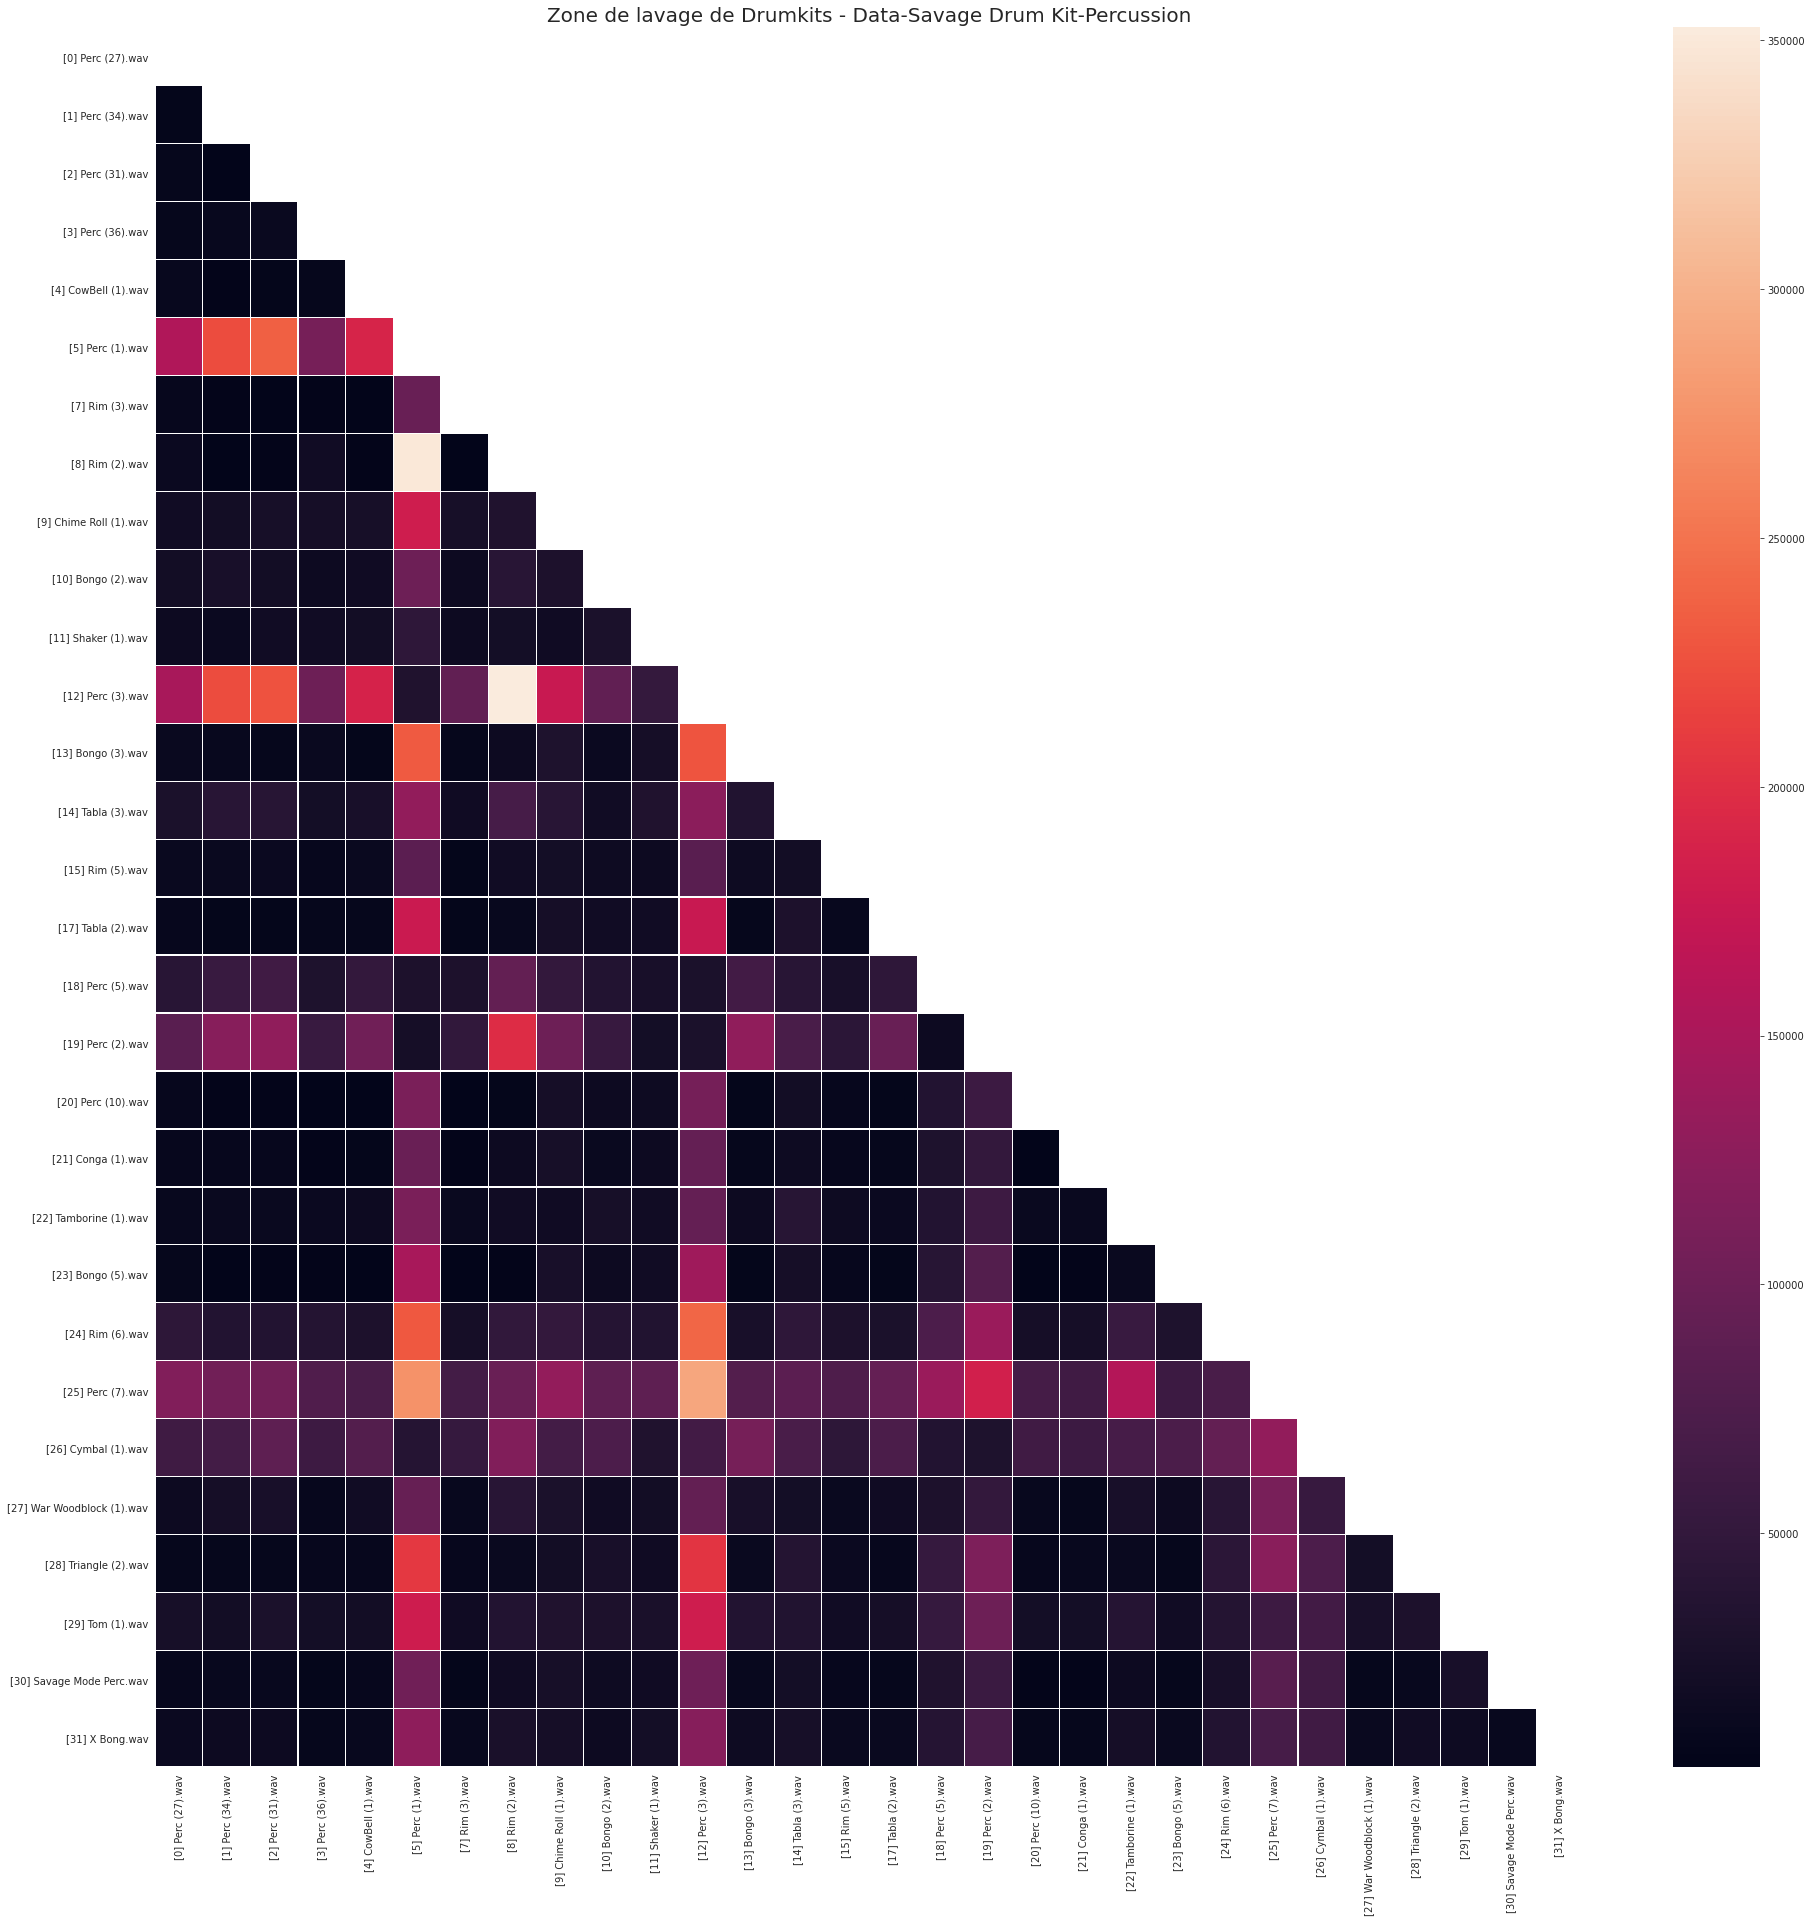

min 3043.059814453125
################################################################################ 83% (10/12) 
### Zone de lavage de Drumkits - Data-Savage Drum Kit-Snaps
0%0%50%50%

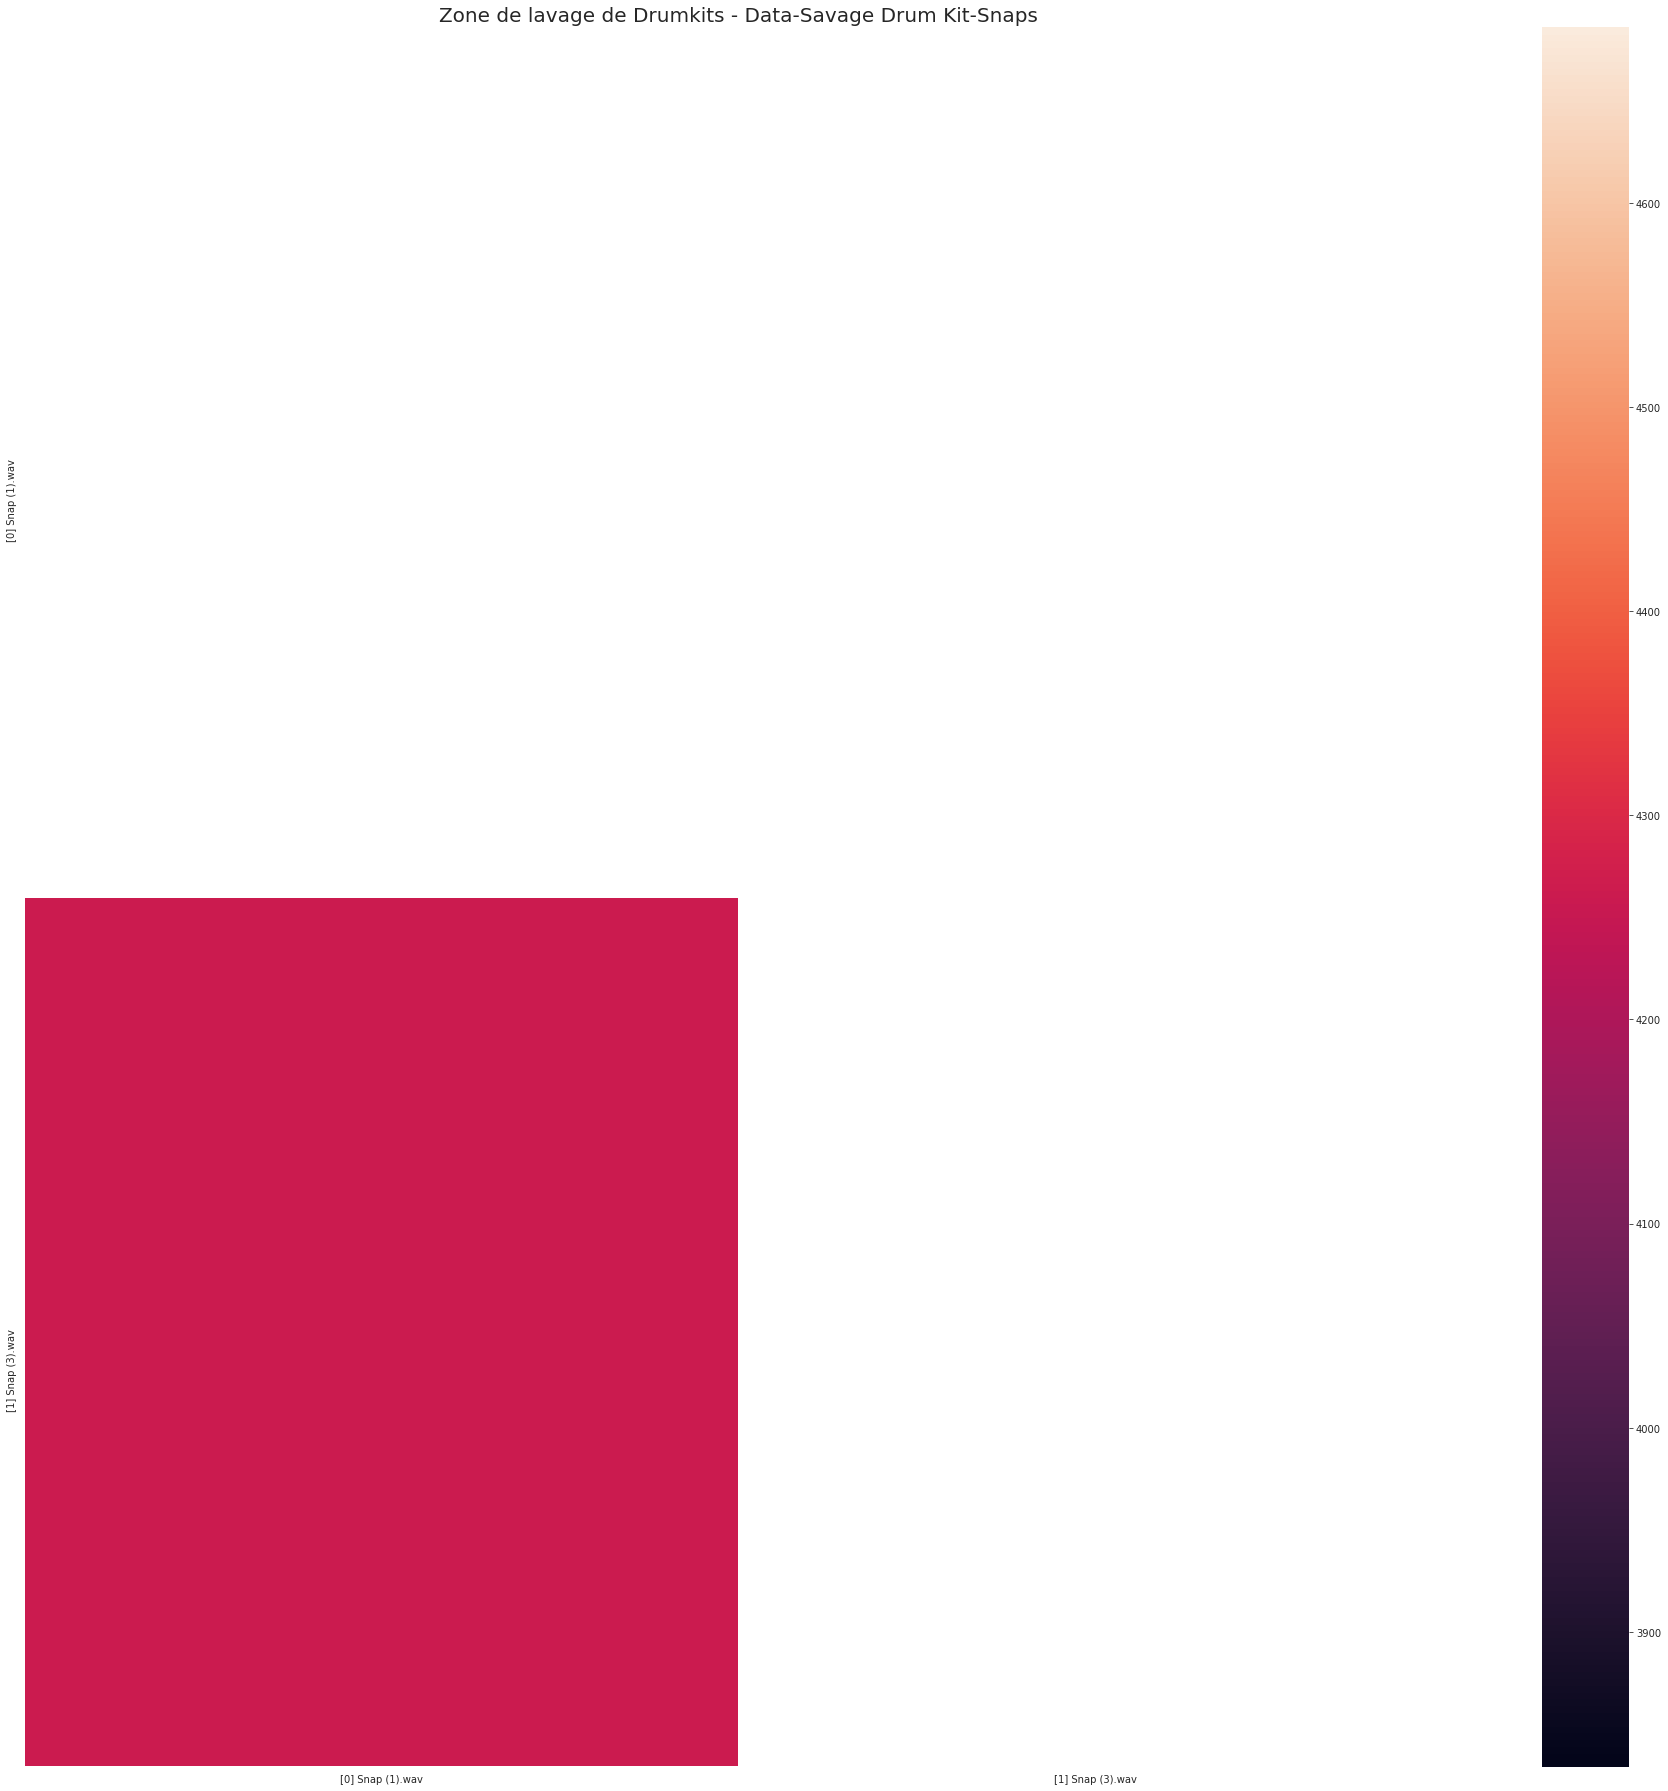

min 4259.933090209961
################################################################################ 92% (11/12) 
### Zone de lavage de Drumkits - Data-Savage Drum Kit-Snares
0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%0%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1911
  n_fft, y.shape[-1]


1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%1%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%3%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%5%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%7%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%9%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%11%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%12%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%14%1

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1950
  n_fft, y.shape[-1]


20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%20%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%22%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%24%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%25%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%27%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%29%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1746
  n_fft, y.shape[-1]


31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%31%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1749
  n_fft, y.shape[-1]


33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%33%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1975
  n_fft, y.shape[-1]


35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%35%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%37%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%38%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%40%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%42%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%44%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=919
  n_fft, y.shape[-1]


46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%46%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1500
  n_fft, y.shape[-1]


48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%48%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%50%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%51%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%53%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1266
  n_fft, y.shape[-1]


55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%55%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%57%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%59%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%61%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%62%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2025
  n_fft, y.shape[-1]


64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%64%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%66%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%68%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%70%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%72%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%74%75%75%75%75%75%75%75%75%75%7

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1669
  n_fft, y.shape[-1]


83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%83%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%85%

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=812
  n_fft, y.shape[-1]


87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%87%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%88%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%90%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%92%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%94%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%96%98%98%98%98%98%98%98%98%98%9

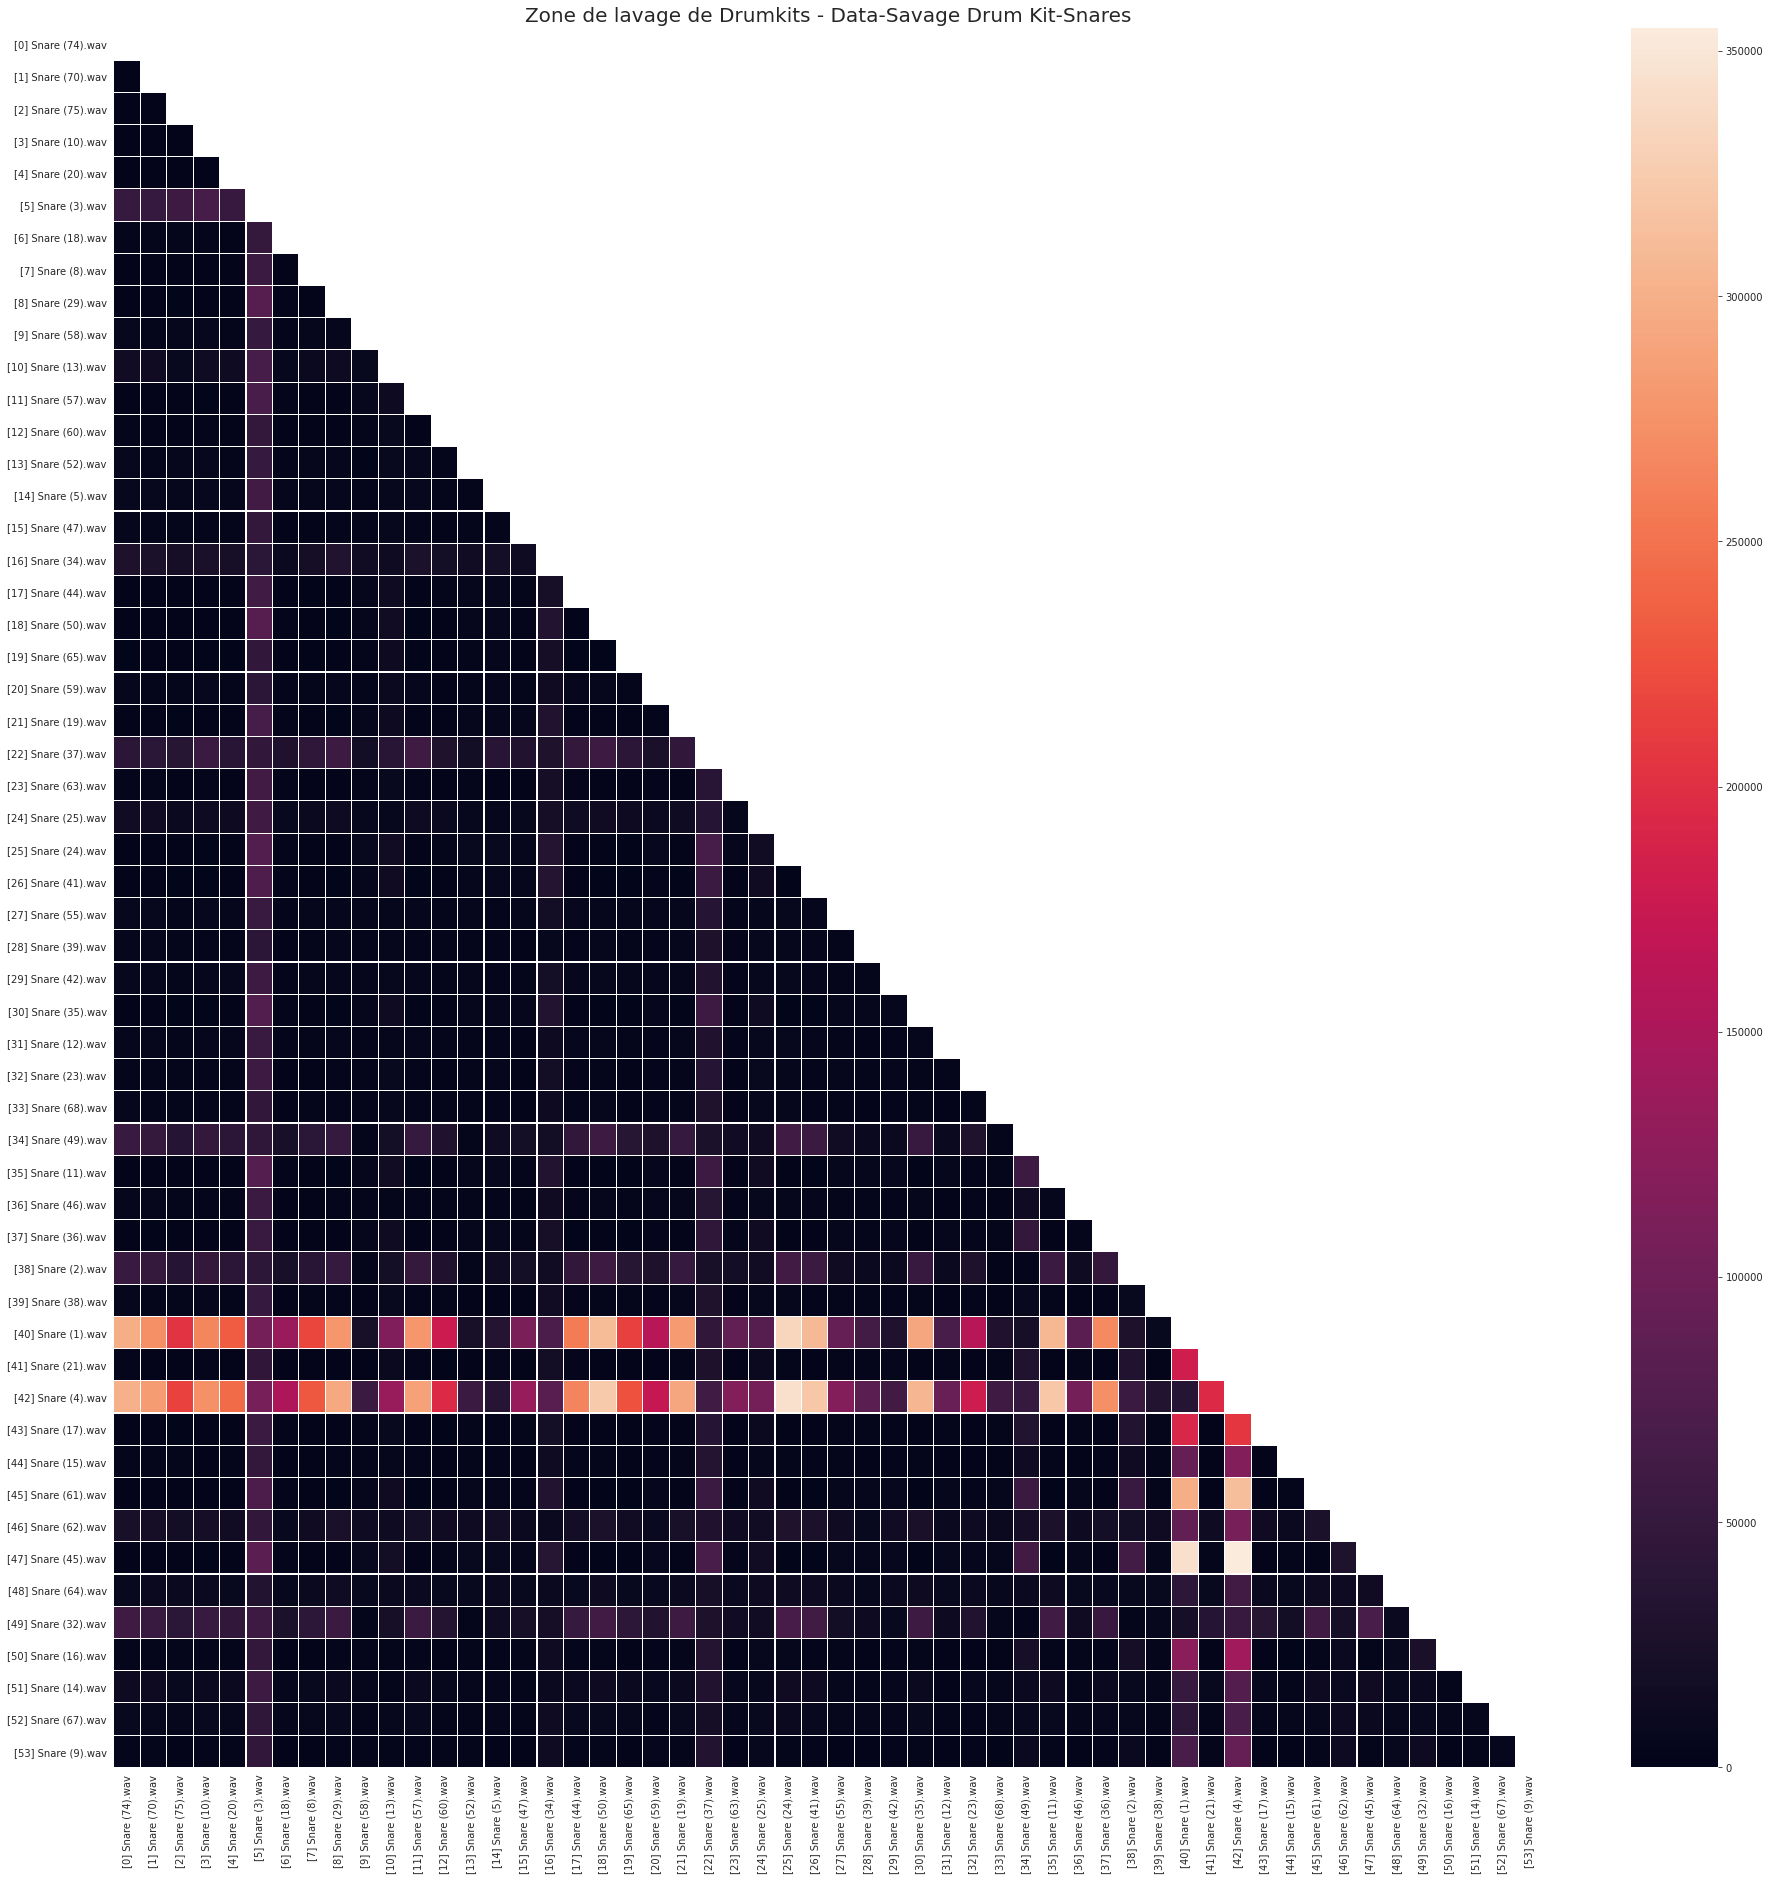

min 0.0
#            Snare (52).wav <-->            Snare (58).wav :   0.0 
#            Snare (44).wav <-->             Snare (8).wav : 1158.5 
#            Snare (50).wav <-->            Snare (29).wav : 899.1 
#            Snare (50).wav <-->            Snare (57).wav : 1151.7 
#            Snare (65).wav <-->            Snare (74).wav : 1196.7 
#            Snare (65).wav <-->            Snare (10).wav : 1018.4 
#            Snare (65).wav <-->             Snare (8).wav : 1162.5 
#            Snare (65).wav <-->            Snare (57).wav : 1206.9 
#            Snare (65).wav <-->            Snare (44).wav : 1096.0 
#            Snare (65).wav <-->            Snare (50).wav : 1139.5 
#            Snare (24).wav <-->            Snare (10).wav : 952.9 
#            Snare (41).wav <-->            Snare (10).wav : 1143.0 
#            Snare (41).wav <-->            Snare (29).wav : 1150.5 
#            Snare (41).wav <-->            Snare (50).wav : 805.1 
#            Snare (41).wav <-

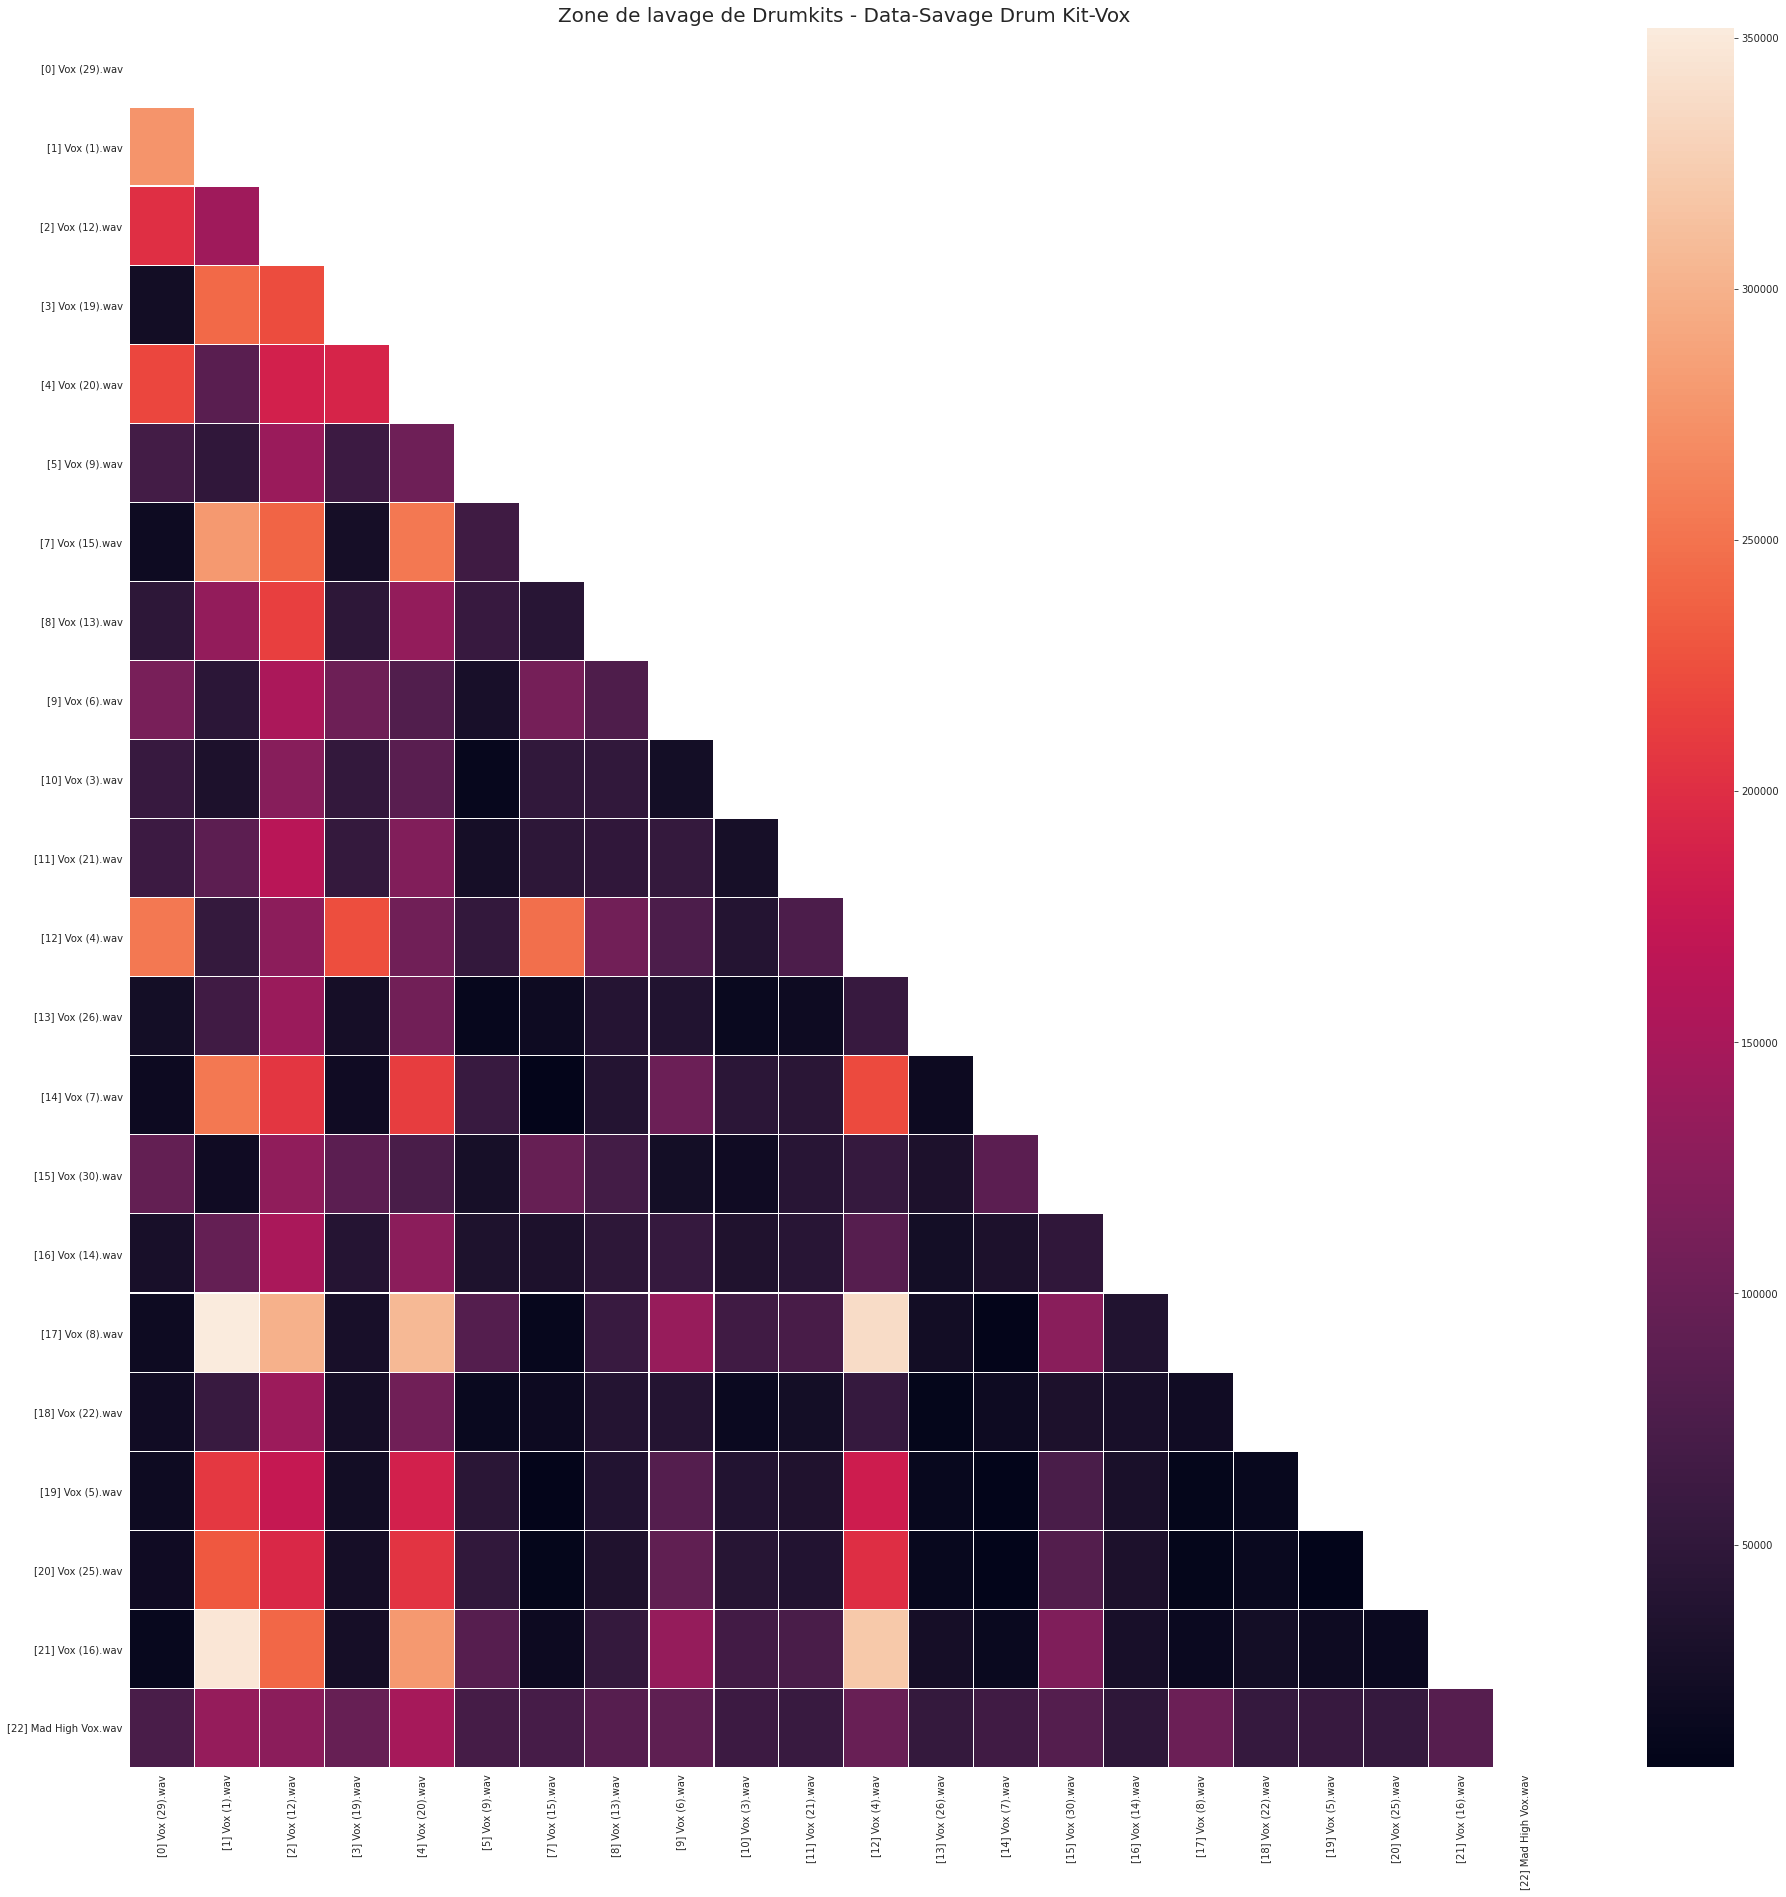

min 5633.167724609375


In [14]:

dateajd = datetime.datetime.now().strftime('%Y')
DRIVE_LEDOSSIER = "/content/gdrive/Shareddrives/# Zone de Code #/• Wanabilini The Producer TOOLS"
DRIVE_LEDOSSIER = CreerDossierSauvegarde(  CreerDossierSauvegarde(DRIVE_LEDOSSIER ,"save"),dateajd + " • " + DRUMKIT_LEDOSSIER.split("/")[-1] )

all_dossier_a_analyser_DRUMKIT = sorted(list(set(get_all_directory(DRUMKIT_LEDOSSIER,l_dossiers_veski))))
for i, dir_drums in enumerate(all_dossier_a_analyser_DRUMKIT):
    
    we_title = "-".join(dir_drums.split("/")[-3:] )
    print('#'*80,f"{int(round((((i+1)/len(all_dossier_a_analyser_DRUMKIT))*100),0))}% ({i+1}/{len(all_dossier_a_analyser_DRUMKIT)}) " )
    print('###',we_title)
    listeFichiersAUDIO_names, listeFichiersAUDIO = get_names_files_on(dir_drums)

    if len(listeFichiersAUDIO) > 1:
        
        if not heatMap_file_exist(we_title):
            # Construire matrice
            tab = matrice_similitude_listes_audios(listeFichiersAUDIO)
            # Graphique 
            CreateHeatMap(tab, listeFichiersAUDIO_names, we_title)
            # Ecrire les fichiers audio similaires
            print("min" , np.nanmin(tab))
            write_resultats_drums(tab,we_title,listeFichiersAUDIO )
        else:
            print("ya deja mgl")
    else:
        print("eh frr.. ya rien")